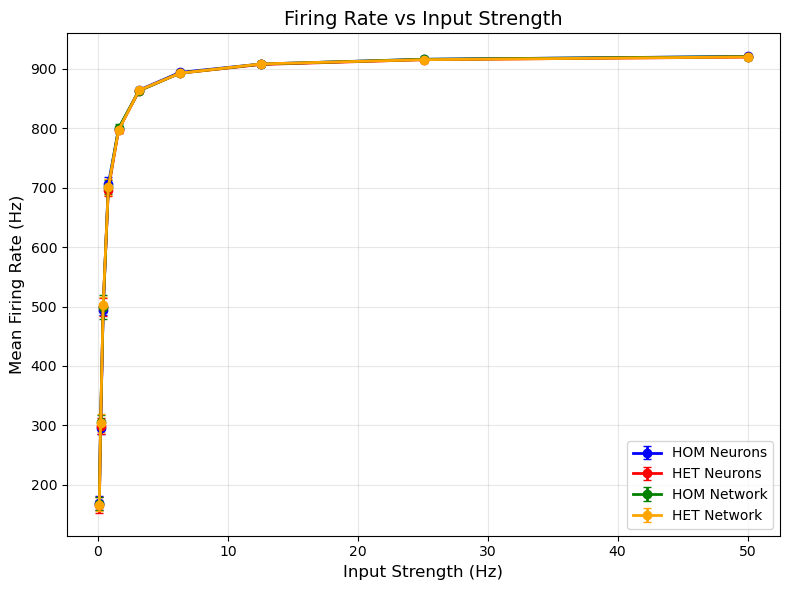

In [163]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load data
filename = 'results/data/spontaneous_session_2_dynamic.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Define conditions
conditions = [
    {'v_th_std': 0, 'g_std': 0, 'label': 'HOM Neurons', 'color': 'blue'},
    {'v_th_std': np.linspace(0,1,10)[-1], 'g_std': 0, 'label': 'HET Neurons', 'color': 'red'},
    {'v_th_std': 0, 'g_std': 1, 'label': 'HOM Network', 'color': 'green'},
    {'v_th_std': np.linspace(0,1,10)[-1], 'g_std': np.linspace(0,1,10)[4], 'label': 'HET Network', 'color': 'orange'}
]

# Plot
plt.figure(figsize=(8, 6))

for cond in conditions:
    # Filter data for this condition
    data = [r for r in results if r['v_th_std'] == cond['v_th_std'] and r['g_std'] == cond['g_std']]
    
    # Sort by input rate
    data.sort(key=lambda x: x['static_input_rate'])
    
    # Extract values
    input_rates = [d['static_input_rate'] for d in data]
    # mean_fr = [d['mean_firing_rate_mean'] for d in data]
    # std_fr = [d['mean_firing_rate_std'] for d in data]
    mean_fr = [d['effective_dimensionality_bin_0.1ms_mean'] for d in data]
    std_fr = [d['effective_dimensionality_bin_0.1ms_std'] for d in data]
    
    # Plot with error bars
    plt.errorbar(input_rates, mean_fr, yerr=std_fr, 
                 label=cond['label'], color=cond['color'], 
                 marker='o', capsize=3, linewidth=2)

plt.xlabel('Input Strength (Hz)', fontsize=12)
plt.ylabel('Mean Firing Rate (Hz)', fontsize=12)
plt.title('Firing Rate vs Input Strength', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
# ==================== CELL 1: SPONTANEOUS DATA PROCESSING ====================

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Load spontaneous results from sessions 1-5
spont_results = []
for session in range(1, 6):
    filename = f'results/data/spontaneous_session_{session}_dynamic.pkl'
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        spont_results.extend(results)

print(f"Loaded {len(spont_results)} spontaneous results from 5 sessions")

# Extract unique parameter values for spontaneous
spont_v_th_stds = sorted(list(set([r['v_th_std'] for r in spont_results])))
spont_g_stds = sorted(list(set([r['g_std'] for r in spont_results])))
spont_input_rates = sorted(list(set([r['static_input_rate'] for r in spont_results])))

print(f"Spontaneous - v_th_stds: {spont_v_th_stds}")
print(f"Spontaneous - g_stds: {spont_g_stds}")
print(f"Spontaneous - input_rates: {spont_input_rates}")

# PRE-GROUP DATA BY PARAMETERS (THIS IS THE KEY OPTIMIZATION!)
print("Pre-grouping spontaneous data...")
spont_grouped = defaultdict(list)
for r in spont_results:
    key = (r['static_input_rate'], r['v_th_std'], r['g_std'])
    spont_grouped[key].append(r)

# Spontaneous metrics to process
spont_metrics = [
    'percent_active',
    'mean_firing_rate',
    'poisson_isi_fraction',
    'participation_ratio_bin_2.0ms',
    'effective_dimensionality_bin_2.0ms'
]

# Store processed 3D grids for all input rates
print("Processing spontaneous 3D grids...")
spont_grids = {}

for metric in spont_metrics:
    spont_grids[metric] = {}
    
    for input_rate in spont_input_rates:
        grid = np.full((len(spont_g_stds), len(spont_v_th_stds)), np.nan)
        
        for i, g_std in enumerate(spont_g_stds):
            for j, v_th_std in enumerate(spont_v_th_stds):
                key = (input_rate, v_th_std, g_std)
                if key in spont_grouped:
                    all_values = []
                    for r in spont_grouped[key]:
                        all_values.extend(r[f'{metric}_values'])
                    grid[i, j] = np.mean(all_values)
        
        spont_grids[metric][input_rate] = grid

# Process spontaneous rate dependence
print("Processing spontaneous rate dependence...")
spont_rate_dep = {}

for metric in spont_metrics:
    means = []
    stds = []
    
    for rate in spont_input_rates:
        het_means = []
        
        for v_th_std in spont_v_th_stds:
            for g_std in spont_g_stds:
                key = (rate, v_th_std, g_std)
                if key in spont_grouped:
                    all_values = []
                    for r in spont_grouped[key]:
                        all_values.extend(r[f'{metric}_values'])
                    het_means.append(np.mean(all_values))
        
        means.append(np.mean(het_means))
        stds.append(np.std(het_means))
    
    spont_rate_dep[metric] = {'means': np.array(means), 'stds': np.array(stds)}

# Process spontaneous dimensionality vs bin size
spont_bin_sizes = [0.1, 2.0, 5.0, 20.0, 50.0, 100.0]
spont_dim_binsize = {}

for metric_prefix in ['participation_ratio', 'effective_dimensionality']:
    means = []
    stds = []
    
    for bin_size in spont_bin_sizes:
        metric_name = f'{metric_prefix}_bin_{bin_size}ms_values'
        all_values = []
        for r in spont_results:
            values = r[metric_name]
            all_values.extend(values)
        
        means.append(np.mean(all_values))
        stds.append(np.std(all_values))
    
    spont_dim_binsize[metric_prefix] = {
        'bin_sizes': spont_bin_sizes, 
        'means': np.array(means), 
        'stds': np.array(stds)
    }

print("Spontaneous data processing complete!")



Loaded 5000 spontaneous results from 5 sessions
Spontaneous - v_th_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
Spontaneous - g_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
Spontaneous - input_rates: [0.1, 0.19947365987750282, 0.3978974098492567, 0.7937005259840996, 1.5832234876474738, 3.15811383485066, 6.2996052494743635, 12.566053148961805, 25.065966118386303, 50.0]
Pre-grouping spontaneous data...
Processing spontaneous 3D grids...
Processing spontaneous rate dependence...
Spontaneous data processing complete!


In [2]:

# ==================== CELL 2: STABILITY DATA PROCESSING ====================

# Load stability results from sessions 1-5
stab_results = []
for session in range(1, 6):
    filename = f'results/data/stability_session_{session}_dynamic.pkl'
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        stab_results.extend(results)

print(f"\nLoaded {len(stab_results)} stability results from 5 sessions")

# Extract unique parameter values for stability
stab_v_th_stds = sorted(list(set([r['v_th_std'] for r in stab_results])))
stab_g_stds = sorted(list(set([r['g_std'] for r in stab_results])))
stab_input_rates = sorted(list(set([r['static_input_rate'] for r in stab_results])))

print(f"Stability - v_th_stds: {stab_v_th_stds}")
print(f"Stability - g_stds: {stab_g_stds}")
print(f"Stability - input_rates: {stab_input_rates}")

# Stability metrics to process
stab_metrics = [
    'lz_spatial_patterns',
    'shannon_entropy_symbols',
    'shannon_entropy_spikes',
    'unique_patterns_count',
    'post_pert_symbol_sum',
    'settling_time_ms',
    'gamma_window_2ms',
    'kistler_delta_2ms'
]

# Store processed heatmap data for all input rates
stab_heatmaps = {}

for metric in stab_metrics:
    stab_heatmaps[metric] = {}
    
    for input_rate in stab_input_rates:
        grid = np.full((len(stab_g_stds), len(stab_v_th_stds)), np.nan)
        
        for i, g_std in enumerate(stab_g_stds):
            for j, v_th_std in enumerate(stab_v_th_stds):
                all_values = []
                for r in stab_results:
                    if (np.isclose(r['static_input_rate'], input_rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    grid[i, j] = np.mean(all_values)
        
        stab_heatmaps[metric][input_rate] = grid

# Process stability rate dependence
stab_rate_dep = {}

for metric in stab_metrics:
    means = []
    stds = []
    
    for rate in stab_input_rates:
        het_means = []
        
        for v_th_std in stab_v_th_stds:
            for g_std in stab_g_stds:
                all_values = []
                for r in stab_results:
                    if (np.isclose(r['static_input_rate'], rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    het_means.append(np.mean(all_values))
        
        means.append(np.mean(het_means))
        stds.append(np.std(het_means))
    
    stab_rate_dep[metric] = {'means': np.array(means), 'stds': np.array(stds)}

print("Stability data processing complete!")




Loaded 5000 stability results from 5 sessions
Stability - v_th_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
Stability - g_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
Stability - input_rates: [0.1, 0.19947365987750282, 0.3978974098492567, 0.7937005259840996, 1.5832234876474738, 3.15811383485066, 6.2996052494743635, 12.566053148961805, 25.065966118386303, 50.0]
Stability data processing complete!



Plotting spontaneous 3D surfaces for input rate: 50.0 Hz


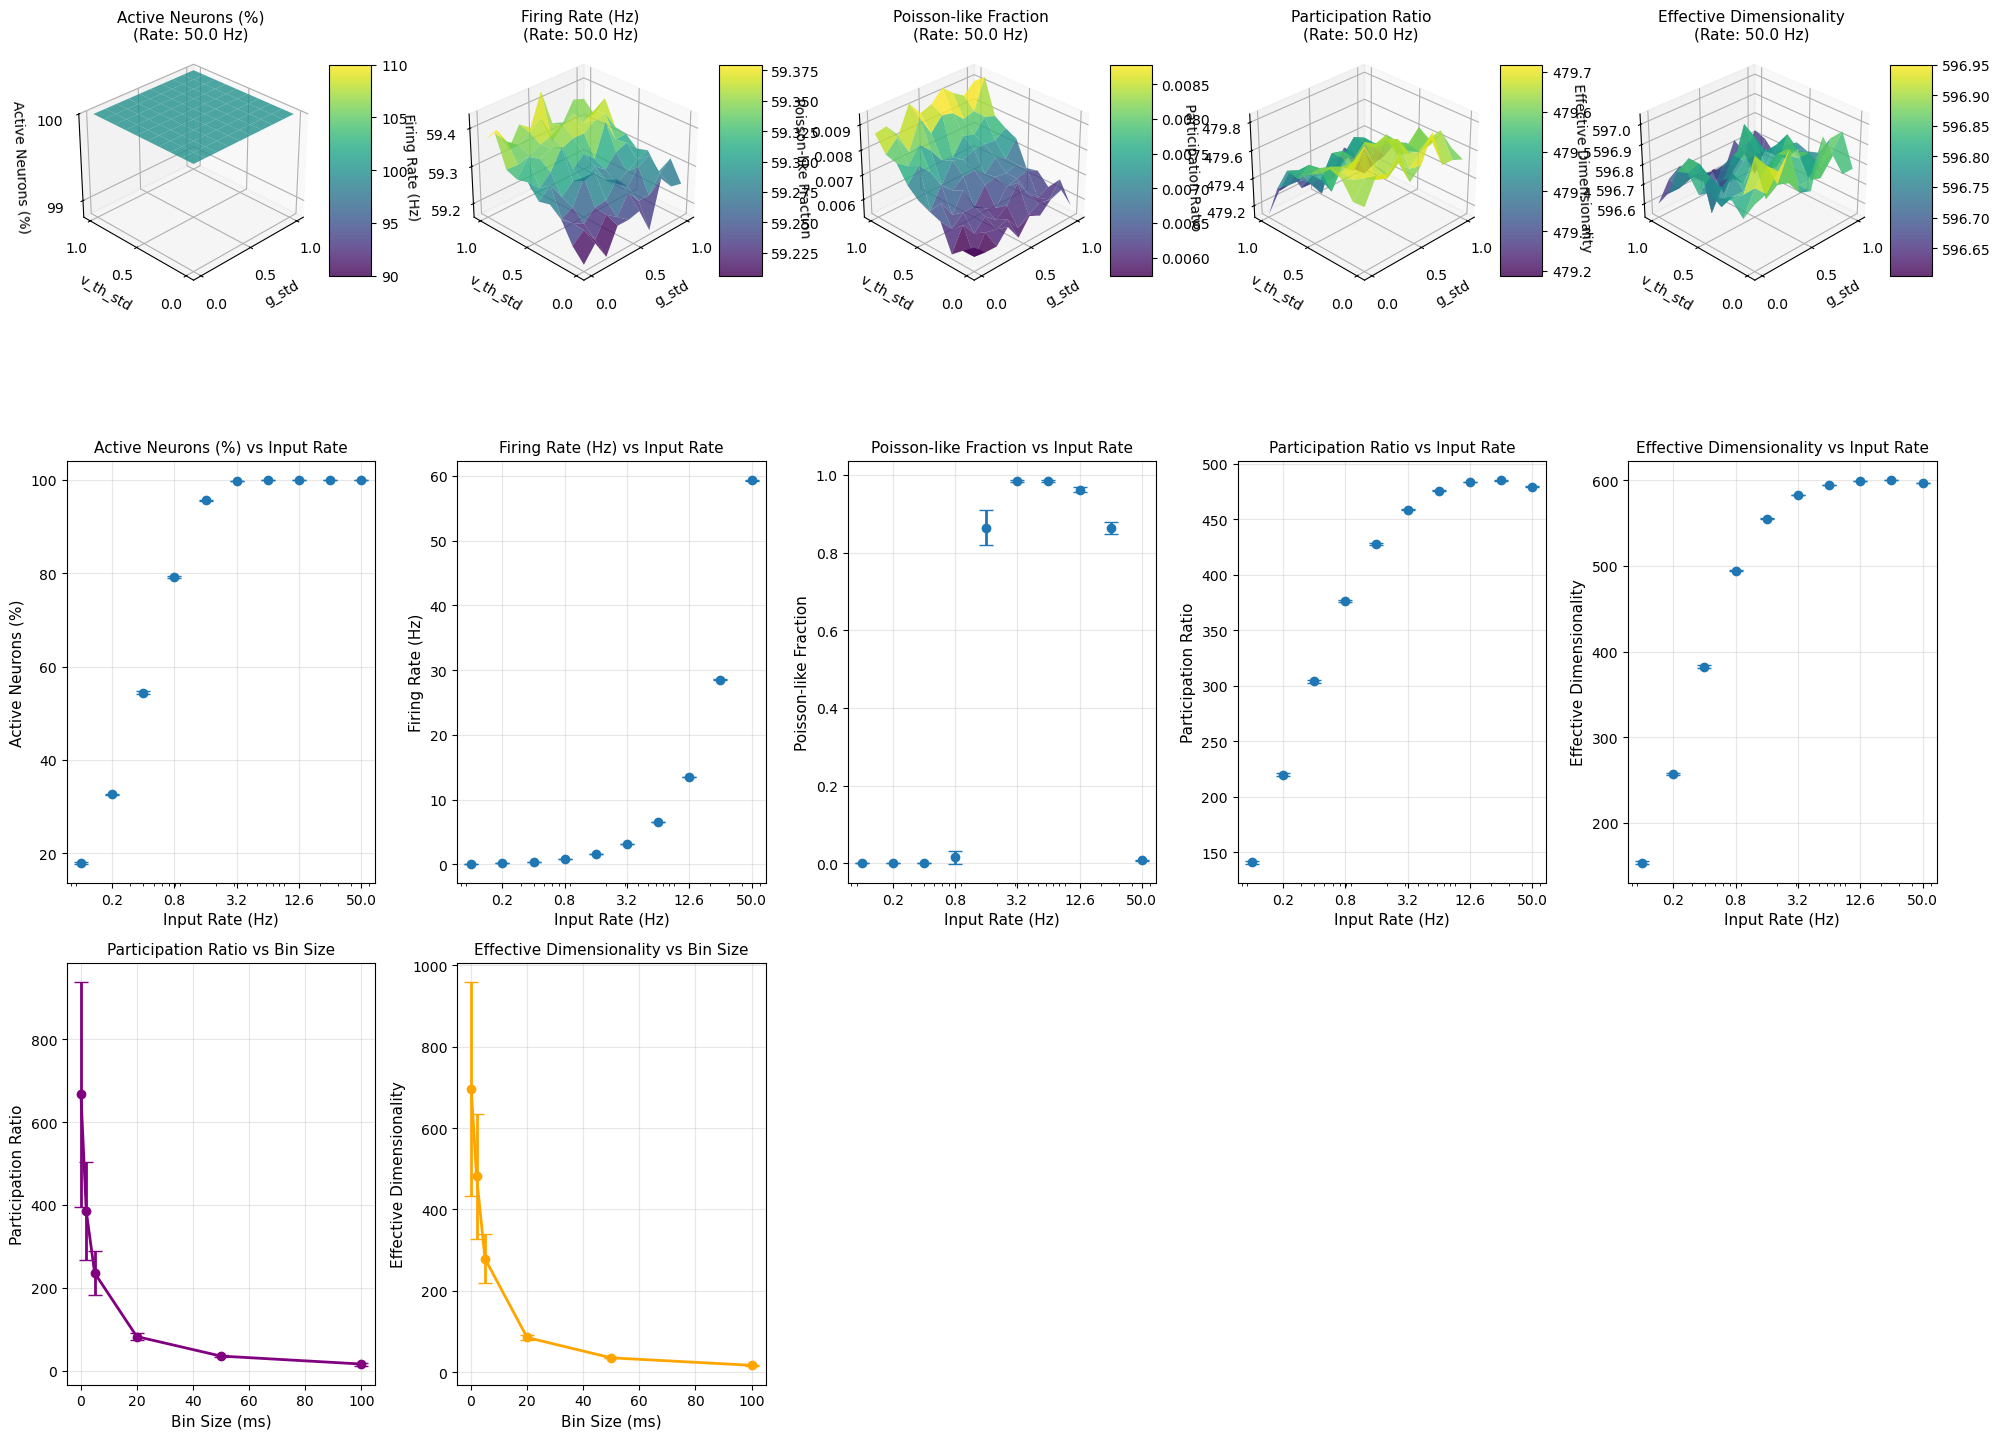

Spontaneous analysis plots saved!


In [9]:

# ==================== CELL 3: SPONTANEOUS PLOTTING ====================

# Select input rate for 3D plots
spont_selected_rate = spont_input_rates[-1]  # Change index to select different rate
print(f"\nPlotting spontaneous 3D surfaces for input rate: {spont_selected_rate} Hz")

# Create meshgrid
spont_V_TH, spont_G = np.meshgrid(spont_v_th_stds, spont_g_stds)

# Metric titles
spont_titles = [
    'Active Neurons (%)',
    'Firing Rate (Hz)',
    'Poisson-like Fraction',
    'Participation Ratio',
    'Effective Dimensionality'
]

# Plotting
fig = plt.figure(figsize=(20, 15))
axs = []

# Row 1: 3D surface plots for selected input rate
for idx, (metric, title) in enumerate(zip(spont_metrics, spont_titles), 1):
    ax = fig.add_subplot(3, 5, idx, projection='3d')
    axs.append(ax)
    
    Z = spont_grids[metric][spont_selected_rate]
    
    surf = ax.plot_surface(spont_G, spont_V_TH, Z, cmap=cm.viridis, alpha=0.8)
    
    ax.view_init(elev=30, azim=225)
    
    ax.set_ylabel('v_th_std', fontsize=10)
    ax.set_xlabel('g_std', fontsize=10)
    ax.set_zlabel(title, fontsize=10)
    ax.set_title(f'{title}\n(Rate: {spont_selected_rate:.1f} Hz)', fontsize=11)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Row 2: 2D plots as function of input rate
for idx, (metric, title) in enumerate(zip(spont_metrics, spont_titles), 6):
    ax = fig.add_subplot(3, 5, idx)
    axs.append(ax)
    
    means = spont_rate_dep[metric]['means']
    stds = spont_rate_dep[metric]['stds']
    
    ax.errorbar(spont_input_rates, means, yerr=stds, fmt='o', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    xticks_to_show = spont_input_rates[1::2]
    ax.set_xticks(xticks_to_show, labels=[f"{x:.1f}" for x in xticks_to_show])

axs = np.array(axs).reshape(2,-1)

axs[0,0].set_zlim((98.8,100))
axs[0,0].set_zticks((99,100))

for i in range(5):
    axs[0,i].set_xticks([0,0.5,1])
    axs[0,i].set_yticks([0,0.5,1])

# Row 3: Dimensionality vs bin size
ax = fig.add_subplot(3, 5, 11)
data = spont_dim_binsize['participation_ratio']
ax.errorbar(data['bin_sizes'], data['means'], yerr=data['stds'], 
            fmt='o-', capsize=5, linewidth=2, markersize=6, color='purple')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Participation Ratio', fontsize=11)
ax.set_title('Participation Ratio vs Bin Size', fontsize=11)
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(3, 5, 12)
data = spont_dim_binsize['effective_dimensionality']
ax.errorbar(data['bin_sizes'], data['means'], yerr=data['stds'], 
            fmt='o-', capsize=5, linewidth=2, markersize=6, color='orange')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Effective Dimensionality', fontsize=11)
ax.set_title('Effective Dimensionality vs Bin Size', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spontaneous_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spontaneous analysis plots saved!")




Plotting stability heatmaps for input rate: 50.0 Hz


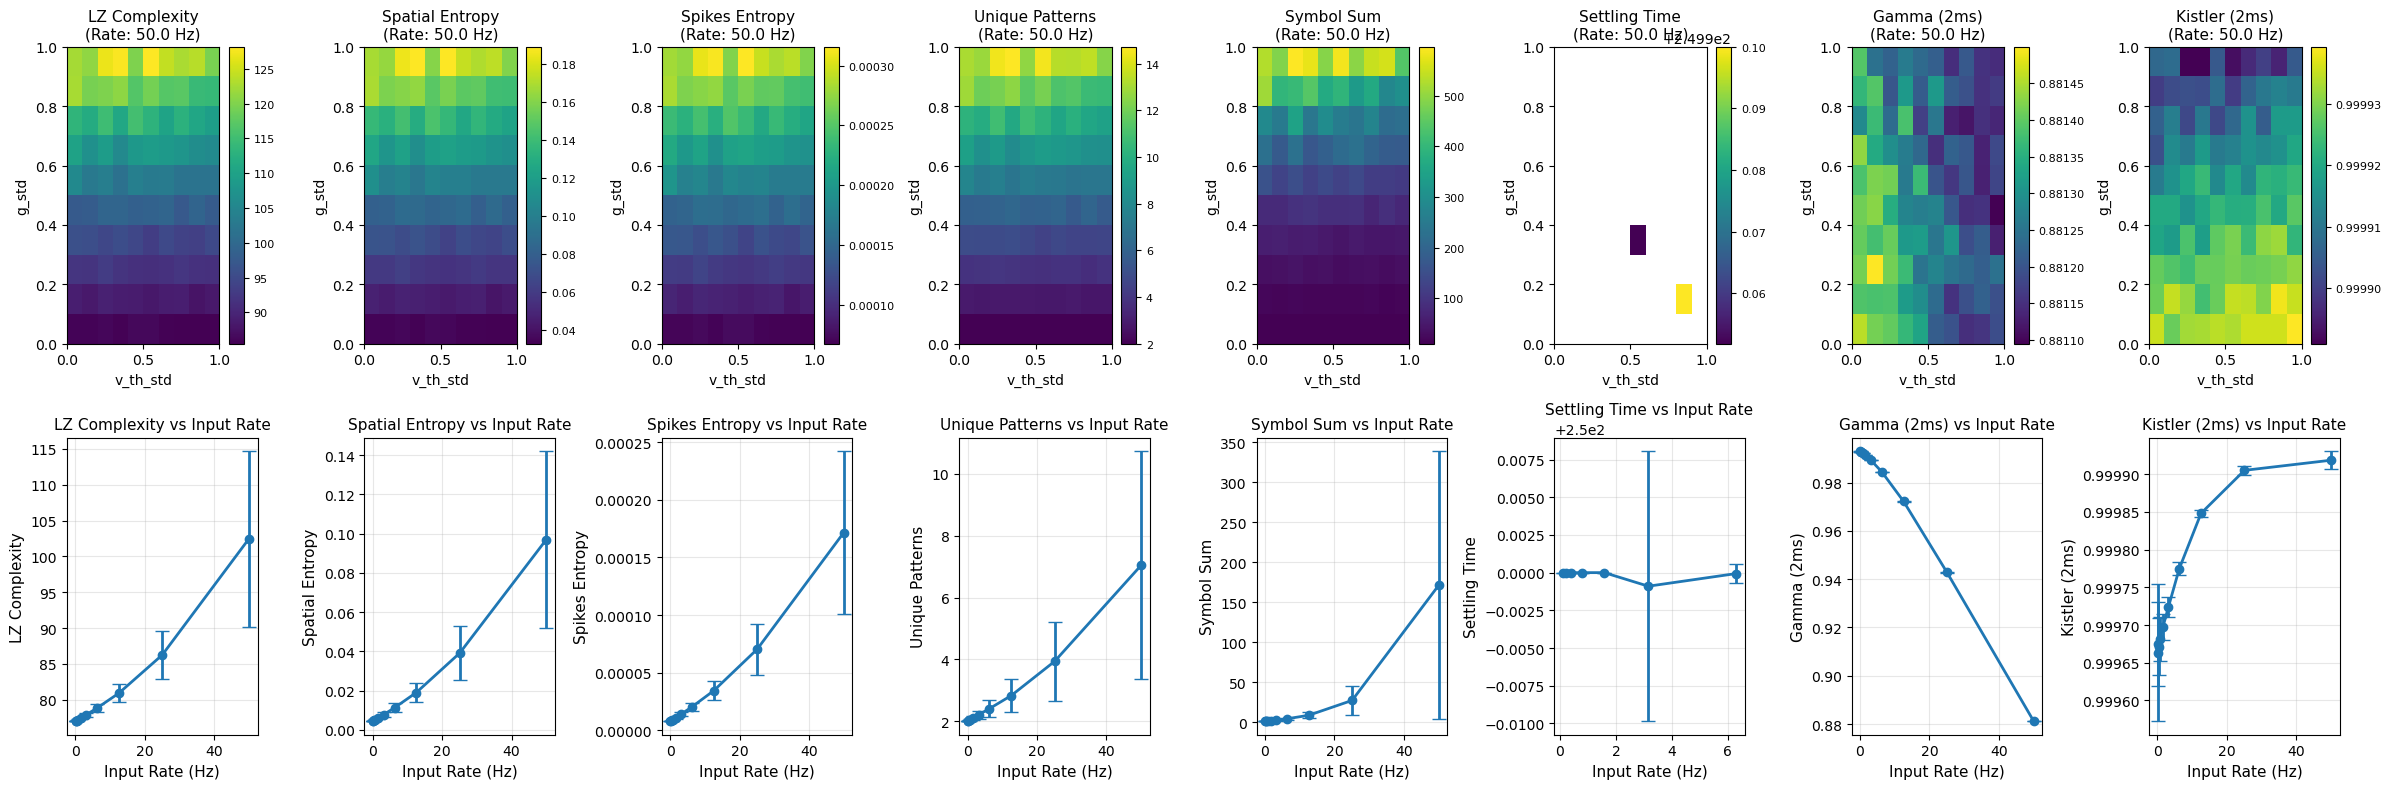

Stability analysis plots saved!


In [7]:

# ==================== CELL 4: STABILITY PLOTTING ====================

# Select input rate for heatmaps
stab_selected_rate = stab_input_rates[-1]  # Change index to select different rate
print(f"\nPlotting stability heatmaps for input rate: {stab_selected_rate} Hz")

# Metric titles
stab_titles = [
    'LZ Complexity',
    'Spatial Entropy',
    'Spikes Entropy',
    'Unique Patterns',
    'Symbol Sum',
    'Settling Time',
    'Gamma (2ms)',
    'Kistler (2ms)'
]

# Plotting
fig = plt.figure(figsize=(24, 8))

# Row 1: Heatmaps for selected input rate
for idx, (metric, title) in enumerate(zip(stab_metrics, stab_titles), 1):
    ax = fig.add_subplot(2, 8, idx)
    
    data = stab_heatmaps[metric][stab_selected_rate]
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='viridis', 
                   extent=[stab_v_th_stds[0], stab_v_th_stds[-1], 
                          stab_g_stds[0], stab_g_stds[-1]])
    
    ax.set_xlabel('v_th_std', fontsize=10)
    ax.set_ylabel('g_std', fontsize=10)
    ax.set_title(f'{title}\n(Rate: {stab_selected_rate:.1f} Hz)', fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Row 2: Line plots as function of input rate
for idx, (metric, title) in enumerate(zip(stab_metrics, stab_titles), 9):
    ax = fig.add_subplot(2, 8, idx)
    
    means = stab_rate_dep[metric]['means']
    stds = stab_rate_dep[metric]['stds']
    
    ax.errorbar(stab_input_rates, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability analysis plots saved!")

In [6]:
10/82

0.12195121951219512

In [8]:
35/90

0.3888888888888889

In [689]:
# ==================== CELL 1: DATA PROCESSING ====================

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Load results from sessions 1-5
all_results = []
for session in range(1, 6):
    filename = f'results/data/spontaneous_session_{session}_dynamic.pkl'
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        all_results.extend(results)

print(f"Loaded {len(all_results)} total results from 5 sessions")

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in all_results])))
g_stds = sorted(list(set([r['g_std'] for r in all_results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in all_results])))

print(f"v_th_stds: {v_th_stds}")
print(f"g_stds: {g_stds}")
print(f"input_rates: {input_rates}")

# Process data for all input rates and metrics
metrics_to_process = [
    'percent_active',
    'mean_firing_rate',
    'poisson_isi_fraction',
    'participation_ratio_bin_2.0ms',
    'effective_dimensionality_bin_2.0ms'
]

# Store processed 3D grids for all input rates
processed_grids = {}

for metric in metrics_to_process:
    processed_grids[metric] = {}
    
    for input_rate in input_rates:
        grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
        
        for i, g_std in enumerate(g_stds):
            for j, v_th_std in enumerate(v_th_stds):
                # Collect all _values arrays for this parameter combination
                all_values = []
                for r in all_results:
                    if (np.isclose(r['static_input_rate'], input_rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    grid[i, j] = np.mean(all_values)
        
        processed_grids[metric][input_rate] = grid

# Process data for rate dependence (row 2)
rate_dependence = {}

for metric in metrics_to_process:
    means = []
    stds = []
    
    for rate in input_rates:
        het_means = []
        
        for v_th_std in v_th_stds:
            for g_std in g_stds:
                all_values = []
                for r in all_results:
                    if (np.isclose(r['static_input_rate'], rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    het_means.append(np.mean(all_values))
        
        means.append(np.mean(het_means))
        stds.append(np.std(het_means))
    
    rate_dependence[metric] = {'means': np.array(means), 'stds': np.array(stds)}

# Process dimensionality vs bin size
bin_sizes = [0.1, 2.0, 5.0, 20.0, 50.0, 100.0]
dim_vs_binsize = {}

for metric_prefix in ['participation_ratio', 'effective_dimensionality']:
    means = []
    stds = []
    
    for bin_size in bin_sizes:
        metric_name = f'{metric_prefix}_bin_{bin_size}ms_values'
        all_values = []
        for r in all_results:
            values = r[metric_name]
            all_values.extend(values)
        
        means.append(np.mean(all_values))
        stds.append(np.std(all_values))
    
    dim_vs_binsize[metric_prefix] = {
        'bin_sizes': bin_sizes, 
        'means': np.array(means), 
        'stds': np.array(stds)
    }

print("\nData processing complete!")
print(f"Processed {len(metrics_to_process)} metrics across {len(input_rates)} input rates")

Loaded 5000 total results from 5 sessions
v_th_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
g_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
input_rates: [0.1, 0.19947365987750282, 0.3978974098492567, 0.7937005259840996, 1.5832234876474738, 3.15811383485066, 6.2996052494743635, 12.566053148961805, 25.065966118386303, 50.0]

Data processing complete!
Processed 5 metrics across 10 input rates


Plotting 3D surfaces for input rate: 50.0 Hz


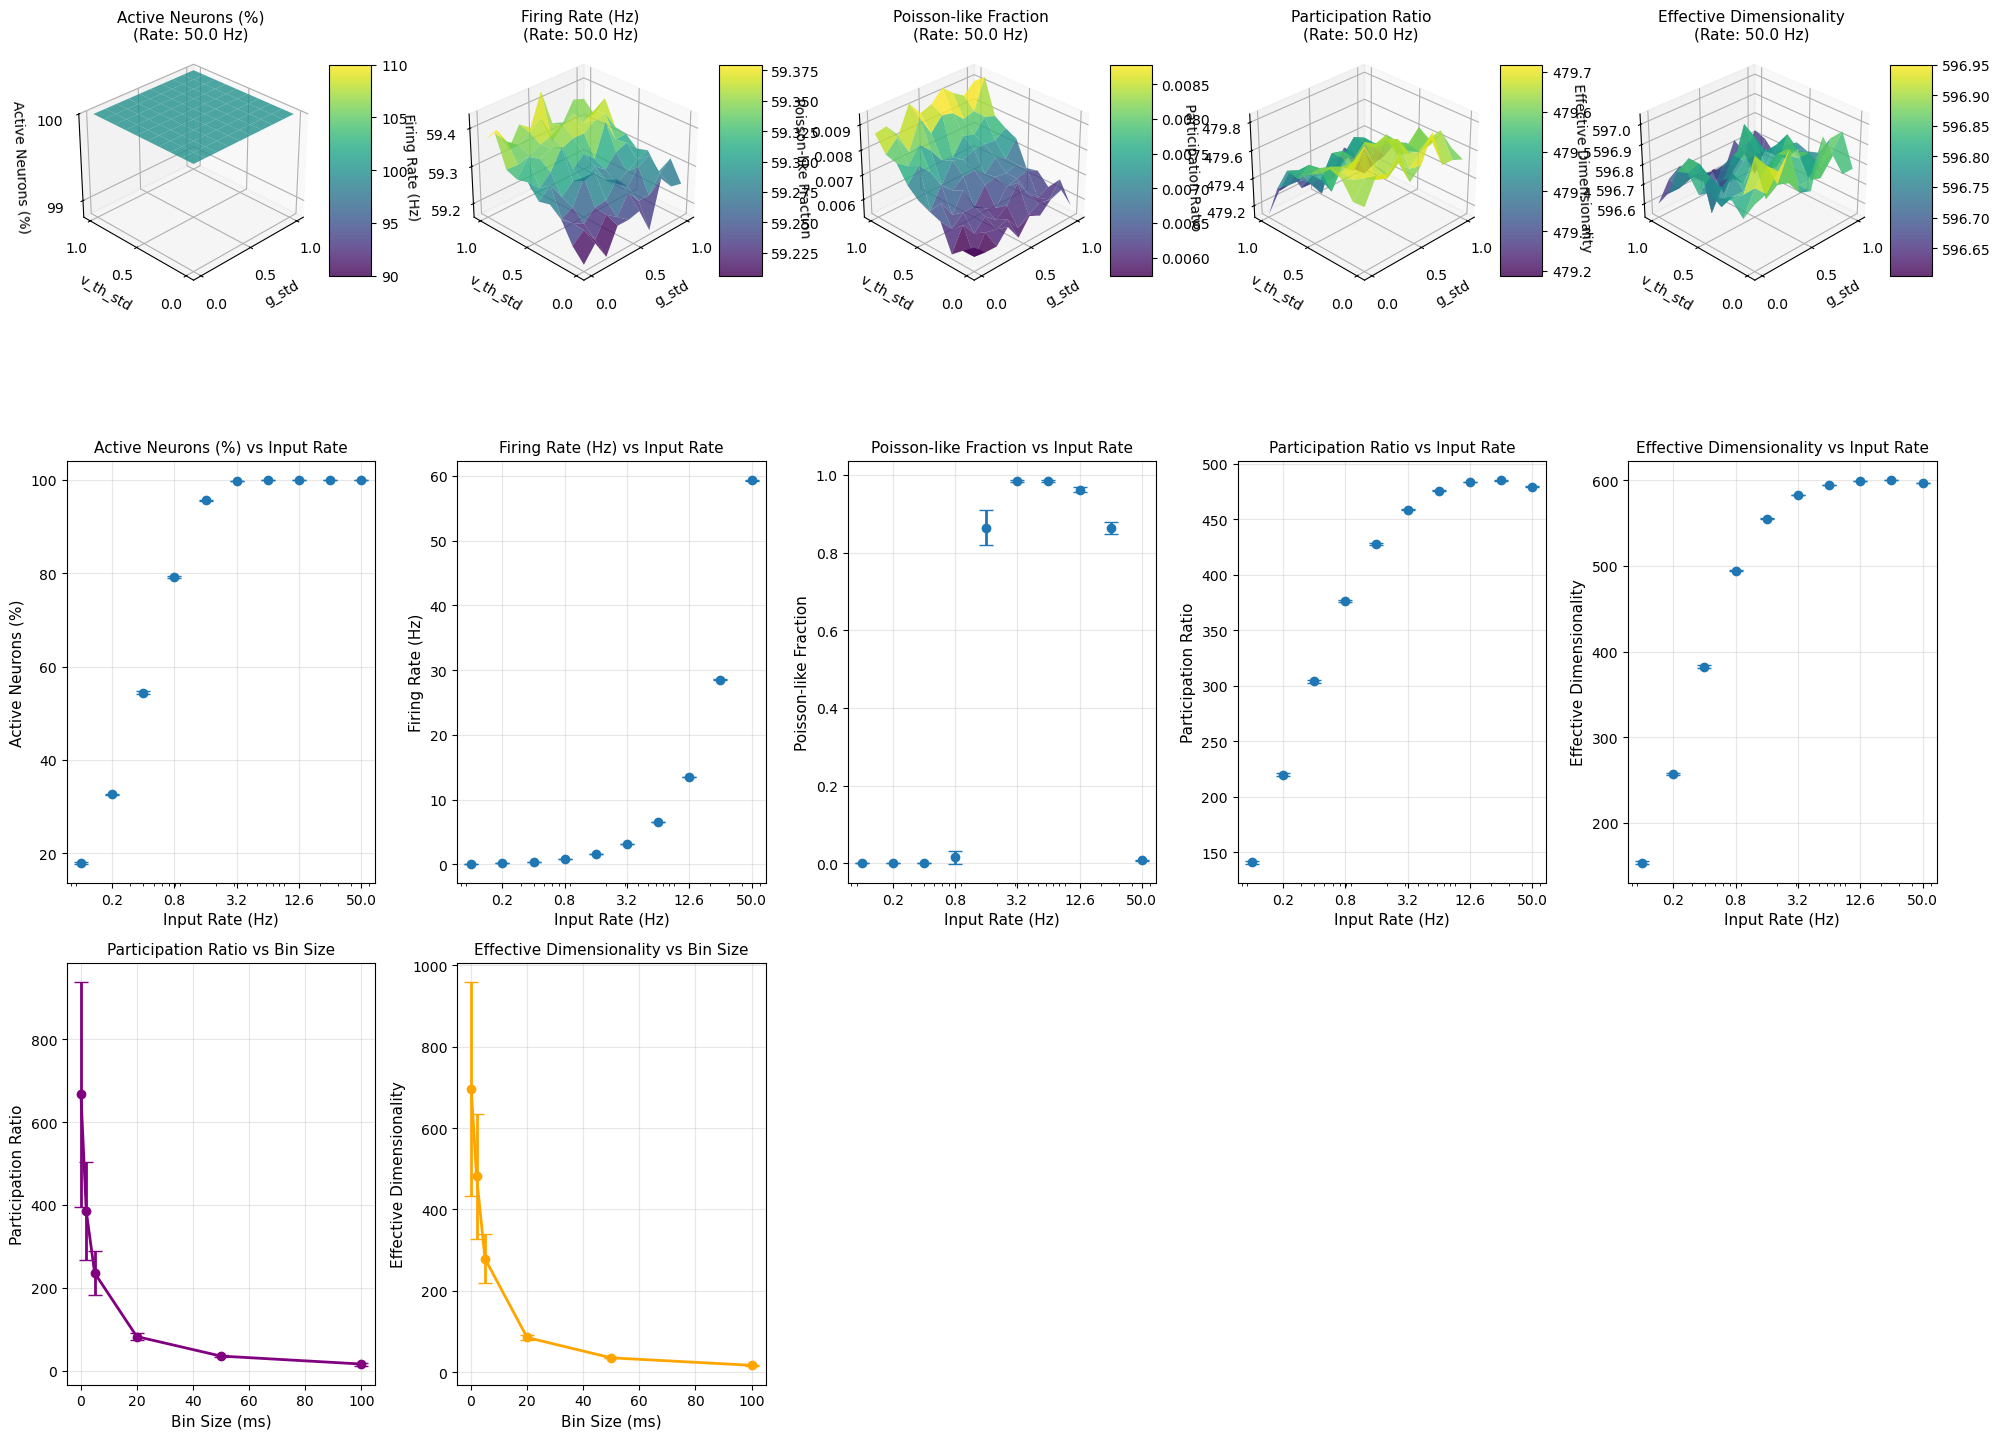

Spontaneous activity plots saved as 'spontaneous_analysis.png'


In [690]:
# ==================== CELL 2: PLOTTING ====================

# Select input rate for 3D plots
selected_rate = input_rates[9]  # Change this index to select different input rate
print(f"Plotting 3D surfaces for input rate: {selected_rate} Hz")

# Create meshgrid
V_TH, G = np.meshgrid(v_th_stds, g_stds)


# Plotting
fig = plt.figure(figsize=(20, 15))
axs = []

# Metric titles
metric_titles = [
    'Active Neurons (%)',
    'Firing Rate (Hz)',
    'Poisson-like Fraction',
    'Participation Ratio',
    'Effective Dimensionality'
]

# Row 1: 3D surface plots for selected input rate
for idx, (metric, title) in enumerate(zip(metrics_to_process, metric_titles), 1):
    ax = fig.add_subplot(3, 5, idx, projection='3d')
    axs.append(ax)
    
    Z = processed_grids[metric][selected_rate]
    
    surf = ax.plot_surface(G, V_TH, Z, cmap=cm.viridis, alpha=0.8)
    
    ax.view_init(elev=30, azim=225)
    
    ax.set_ylabel('v_th_std', fontsize=10)
    ax.set_xlabel('g_std', fontsize=10)
    ax.set_zlabel(title, fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    

# Row 2: 2D plots as function of input rate
for idx, (metric, title) in enumerate(zip(metrics_to_process, metric_titles), 6):
    ax = fig.add_subplot(3, 5, idx)
    axs.append(ax)
    
    means = rate_dependence[metric]['means']
    stds = rate_dependence[metric]['stds']
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    xticks_to_show = input_rates[1::2]
    ax.set_xticks(xticks_to_show, labels=[f"{x:.1f}" for x in xticks_to_show])

axs = np.array(axs).reshape(2,-1)

axs[0,0].set_zlim((98.8,100))
axs[0,0].set_zticks((99,100))

for i in range(5):
    axs[0,i].set_xticks([0,0.5,1])
    axs[0,i].set_yticks([0,0.5,1])

# Row 3: Dimensionality vs bin size
ax = fig.add_subplot(3, 5, 11)
data = dim_vs_binsize['participation_ratio']
ax.errorbar(data['bin_sizes'], data['means'], yerr=data['stds'], 
            fmt='o-', capsize=5, linewidth=2, markersize=6, color='purple')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Participation Ratio', fontsize=11)
ax.set_title('Participation Ratio vs Bin Size', fontsize=11)
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(3, 5, 12)
data = dim_vs_binsize['effective_dimensionality']
ax.errorbar(data['bin_sizes'], data['means'], yerr=data['stds'], 
            fmt='o-', capsize=5, linewidth=2, markersize=6, color='orange')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Effective Dimensionality', fontsize=11)
ax.set_title('Effective Dimensionality vs Bin Size', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spontaneous_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spontaneous activity plots saved as 'spontaneous_analysis.png'")

In [687]:
# ==================== CELL 1: DATA PROCESSING ====================

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load results from sessions 1-5
all_results_stability = []
for session in range(1, 6):
    filename = f'results/data/stability_session_{session}_dynamic.pkl'
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        all_results_stability.extend(results)

print(f"Loaded {len(all_results_stability)} total results from 5 sessions")

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in all_results_stability])))
g_stds = sorted(list(set([r['g_std'] for r in all_results_stability])))
input_rates = sorted(list(set([r['static_input_rate'] for r in all_results_stability])))

print(f"v_th_stds: {v_th_stds}")
print(f"g_stds: {g_stds}")
print(f"input_rates: {input_rates}")

# Metrics to process
metrics_to_process = [
    'lz_spatial_patterns',
    'shannon_entropy_symbols',
    'shannon_entropy_spikes',
    'unique_patterns_count',
    'post_pert_symbol_sum',
    'settling_time_ms',
    'gamma_window_2ms',
    'kistler_delta_2ms'
]

# Store processed heatmap data for all input rates
processed_heatmaps_stability = {}

for metric in metrics_to_process:
    processed_heatmaps_stability[metric] = {}
    
    for input_rate in input_rates:
        grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
        
        for i, g_std in enumerate(g_stds):
            for j, v_th_std in enumerate(v_th_stds):
                # Collect all _values arrays for this parameter combination
                all_values = []
                for r in all_results_stability:
                    if (np.isclose(r['static_input_rate'], input_rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    grid[i, j] = np.mean(all_values)
        
        processed_heatmaps_stability[metric][input_rate] = grid

# Process data for rate dependence (row 2)
rate_dependence_stability = {}

for metric in metrics_to_process:
    means = []
    stds = []
    
    for rate in input_rates:
        het_means = []
        
        for v_th_std in v_th_stds:
            for g_std in g_stds:
                all_values = []
                for r in all_results_stability:
                    if (np.isclose(r['static_input_rate'], rate) and 
                        r['v_th_std'] == v_th_std and r['g_std'] == g_std):
                        values = r[f'{metric}_values']
                        all_values.extend(values)
                
                if all_values:
                    het_means.append(np.mean(all_values))
        
        means.append(np.mean(het_means))
        stds.append(np.std(het_means))
    
    rate_dependence_stability[metric] = {'means': np.array(means), 'stds': np.array(stds)}

print("\nData processing complete!")
print(f"Processed {len(metrics_to_process)} metrics across {len(input_rates)} input rates")



Loaded 5000 total results from 5 sessions
v_th_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
g_stds: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
input_rates: [0.1, 0.19947365987750282, 0.3978974098492567, 0.7937005259840996, 1.5832234876474738, 3.15811383485066, 6.2996052494743635, 12.566053148961805, 25.065966118386303, 50.0]

Data processing complete!
Processed 8 metrics across 10 input rates


Plotting heatmaps for input rate: 50.0 Hz


KeyError: 'percent_active'

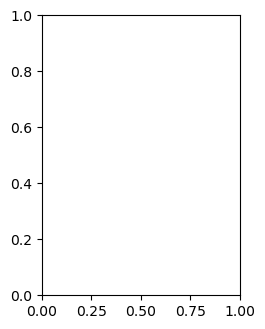

In [692]:

# ==================== CELL 2: PLOTTING ====================

# Select input rate for heatmaps
selected_rate = input_rates[-1]  # Change this to select different input rate
print(f"Plotting heatmaps for input rate: {selected_rate} Hz")

# Metric titles
metric_titles = [
    'LZ Complexity',
    'Spatial Entropy',
    'Spikes Entropy',
    'Unique Patterns',
    'Symbol Sum',
    'Settling Time',
    'Gamma (2ms)',
    'Kistler (2ms)'
]

# Plotting
fig = plt.figure(figsize=(24, 8))

# Row 1: Heatmaps for selected input rate
for idx, (metric, title) in enumerate(zip(metrics_to_process, metric_titles), 1):
    ax = fig.add_subplot(2, 8, idx)
    
    data = processed_heatmaps_stability[metric][selected_rate]
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='viridis', 
                   extent=[v_th_stds[0], v_th_stds[-1], g_stds[0], g_stds[-1]])
    
    ax.set_xlabel('v_th_std', fontsize=10)
    ax.set_ylabel('g_std', fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Row 2: Line plots as function of input rate
for idx, (metric, title) in enumerate(zip(metrics_to_process, metric_titles), 9):
    ax = fig.add_subplot(2, 8, idx)
    
    means = rate_dependence_stability[metric]['means']
    stds = rate_dependence_stability[metric]['stds']
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability analysis plots saved as 'stability_analysis.png'")

In [691]:
10/90

0.1111111111111111

Plotting 3D surfaces for input rate: 25.065966118386303 Hz


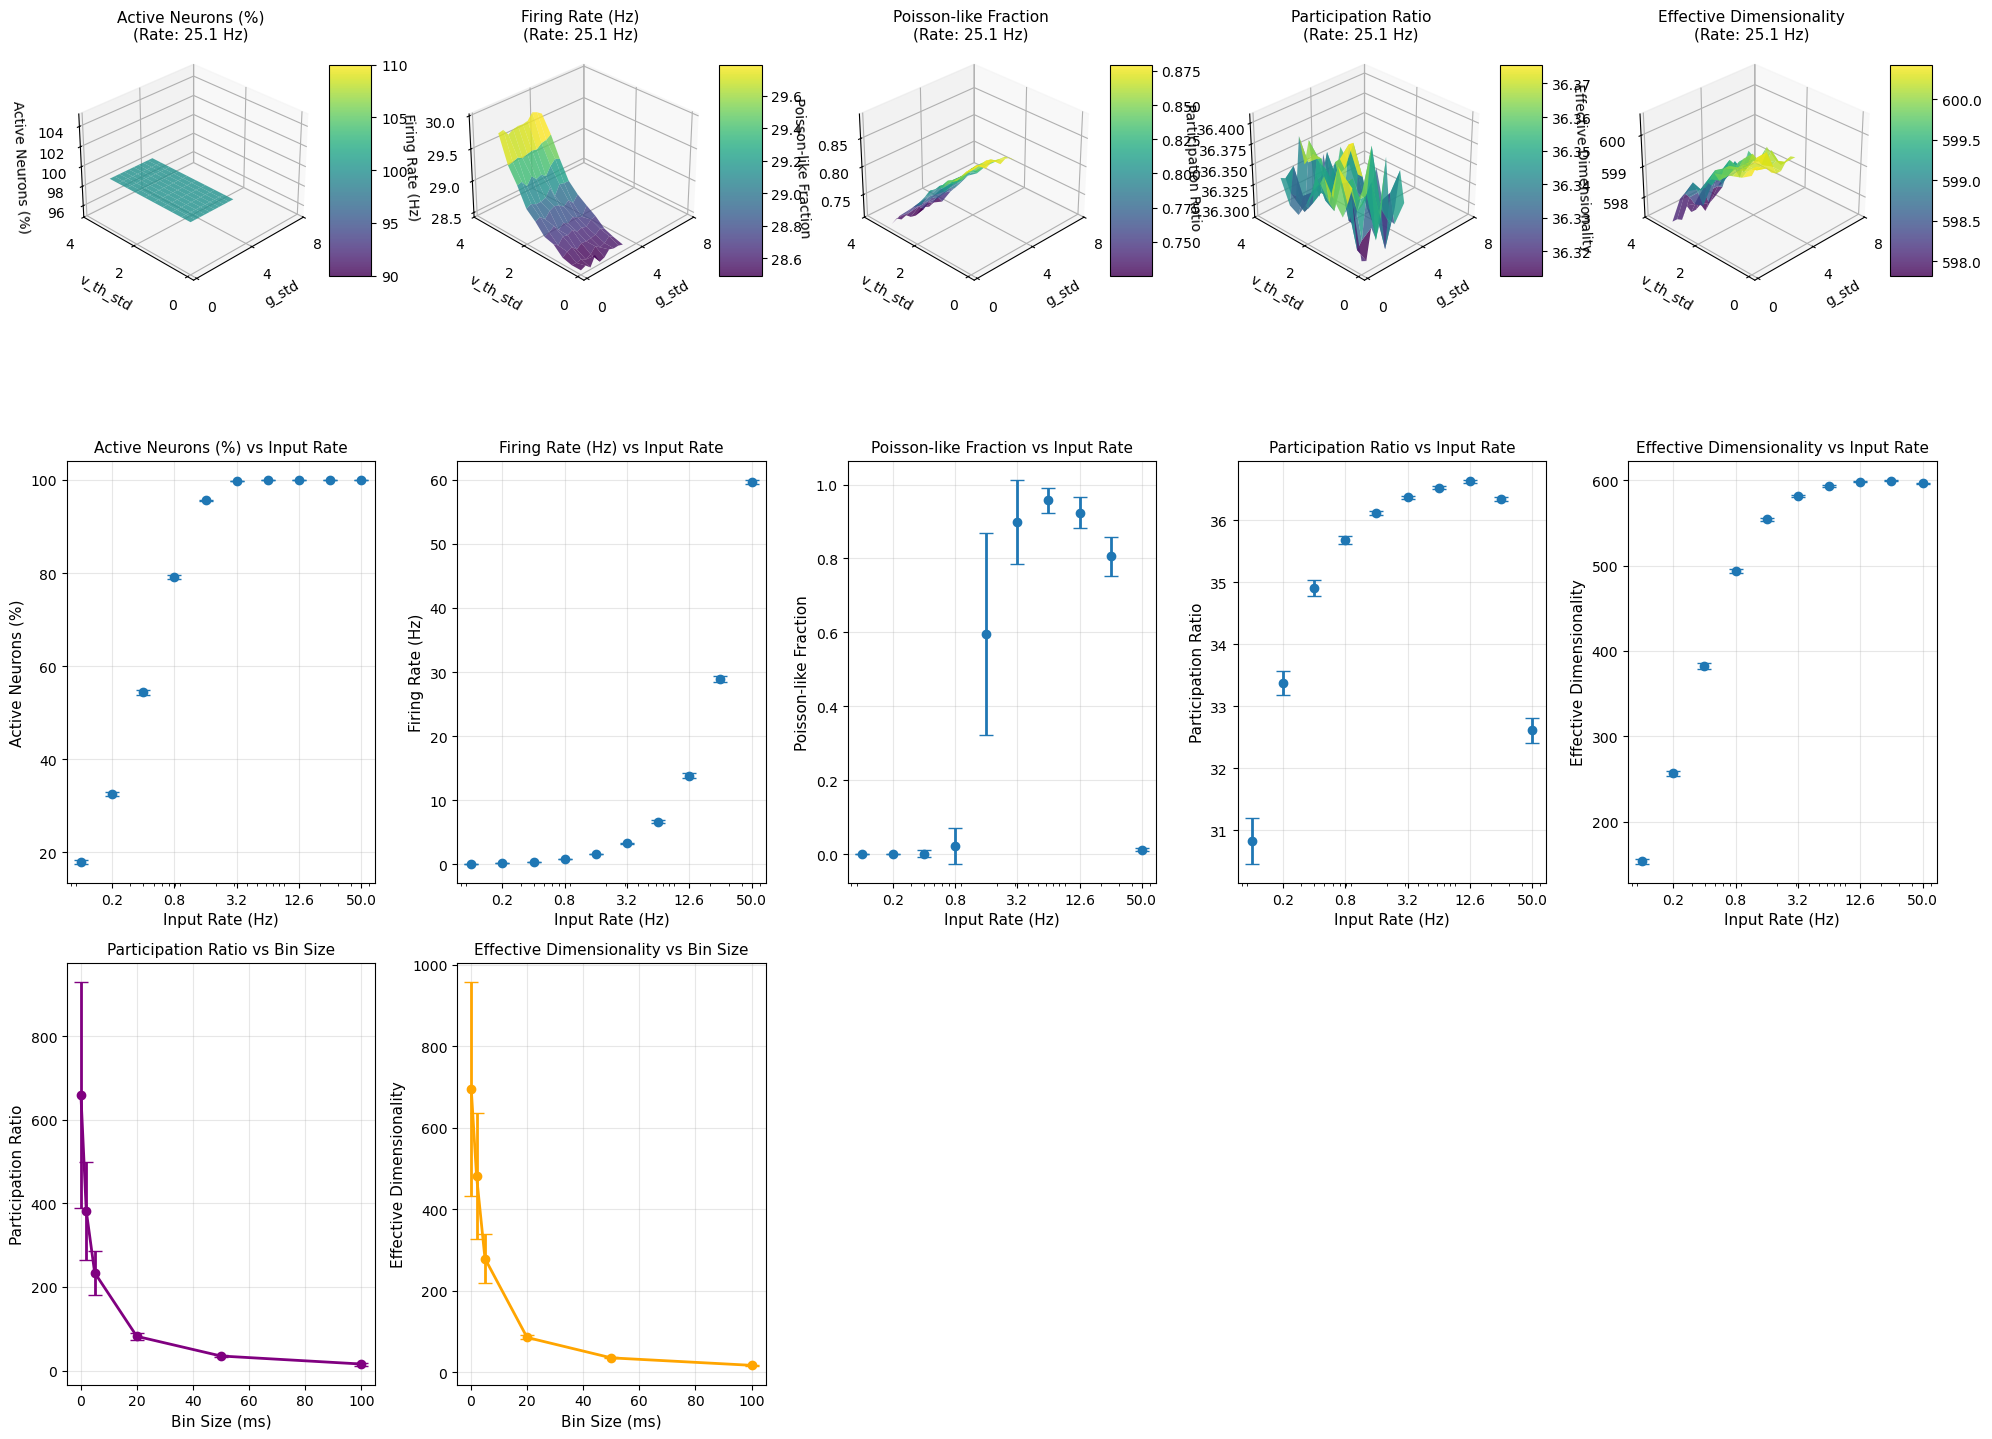

Spontaneous activity plots saved as 'spontaneous_analysis.png'


In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Load results
filename = 'results/data/spontaneous_session_2_dynamic.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# Choose specific input rate for 3D plots
selected_rate = input_rates[len(input_rates)//2]  # Middle rate, adjust as needed
selected_rate = input_rates[-2]
print(f"Plotting 3D surfaces for input rate: {selected_rate} Hz")

# Create meshgrid
V_TH, G = np.meshgrid(v_th_stds, g_stds)

# Function to extract data for specific input rate
def get_data_grid(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for specific input rate"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate):
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates):
    """Average metric across all v_th_std and g_std for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# Function to get dimensionality across bin sizes
def get_dimensionality_vs_binsize(results, metric_prefix):
    """Average dimensionality across all parameters for each bin size"""
    bin_sizes = [0.1, 2.0, 5.0, 20.0, 50.0, 100.0]
    means = []
    stds = []
    
    for bin_size in bin_sizes:
        metric_name = f'{metric_prefix}_bin_{bin_size}ms_mean'
        values = [r[metric_name] for r in results if not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return bin_sizes, np.array(means), np.array(stds)

# ==================== PLOTTING ====================

fig = plt.figure(figsize=(20, 15))
axs = []

# Row 1: 3D surface plots for selected input rate
metrics_3d = [
    ('percent_active_mean', 'Active Neurons (%)'),
    ('mean_firing_rate_mean', 'Firing Rate (Hz)'),
    ('poisson_isi_fraction_mean', 'Poisson-like Fraction'),
    ('participation_ratio_bin_50.0ms_mean', 'Participation Ratio'),
    ('effective_dimensionality_bin_2.0ms_mean', 'Effective Dimensionality')
]

for idx, (metric, title) in enumerate(metrics_3d, 1):
    ax = fig.add_subplot(3, 5, idx, projection='3d')
    axs.append(ax)
    
    Z = get_data_grid(results, metric, selected_rate, v_th_stds, g_stds)
    
    surf = ax.plot_surface(G, V_TH, Z, cmap=cm.viridis, alpha=0.8)
    
    # Set view angle so origin corner is at lowest values
    ax.view_init(elev=30, azim=225)  # Adjust angles as needed
    
    ax.set_ylabel('v_th_std', fontsize=10)
    ax.set_xlabel('g_std', fontsize=10)
    ax.set_zlabel(title, fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Row 2: 2D plots as function of input rate (averaged across v_th_std and g_std)
for idx, (metric, title) in enumerate(metrics_3d, 6):
    ax = fig.add_subplot(3, 5, idx)
    axs.append(ax)
    
    means, stds = get_rate_dependence(results, metric, input_rates)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    xticks_to_show = input_rates[1::2]
    ax.set_xticks(xticks_to_show, labels=[f"{x:.1f}" for x in xticks_to_show])  # Use .1f for 1 decimal, adjust as needed


axs = np.array(axs).reshape(2,-1)

# axs[0,0].set_zlim((98.8,100))
# axs[0,0].set_zticks((99,100))

for i in range(5):
    axs[0,i].set_xticks([0,4,8])
    axs[0,i].set_yticks([0,2,4])

# Row 3: Dimensionality vs bin size
# Column 1: Participation ratio
ax = fig.add_subplot(3, 5, 11)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'participation_ratio')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='purple')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Participation Ratio', fontsize=11)
ax.set_title('Participation Ratio vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Column 2: Effective dimensionality
ax = fig.add_subplot(3, 5, 12)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'effective_dimensionality')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='orange')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Effective Dimensionality', fontsize=11)
ax.set_title('Effective Dimensionality vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spontaneous_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spontaneous activity plots saved as 'spontaneous_analysis.png'")

Plotting 3D surfaces for input rate: 0.0 Hz


/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/4012772854.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/4012772854.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/4012772854.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/4012772854.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/4012772854.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


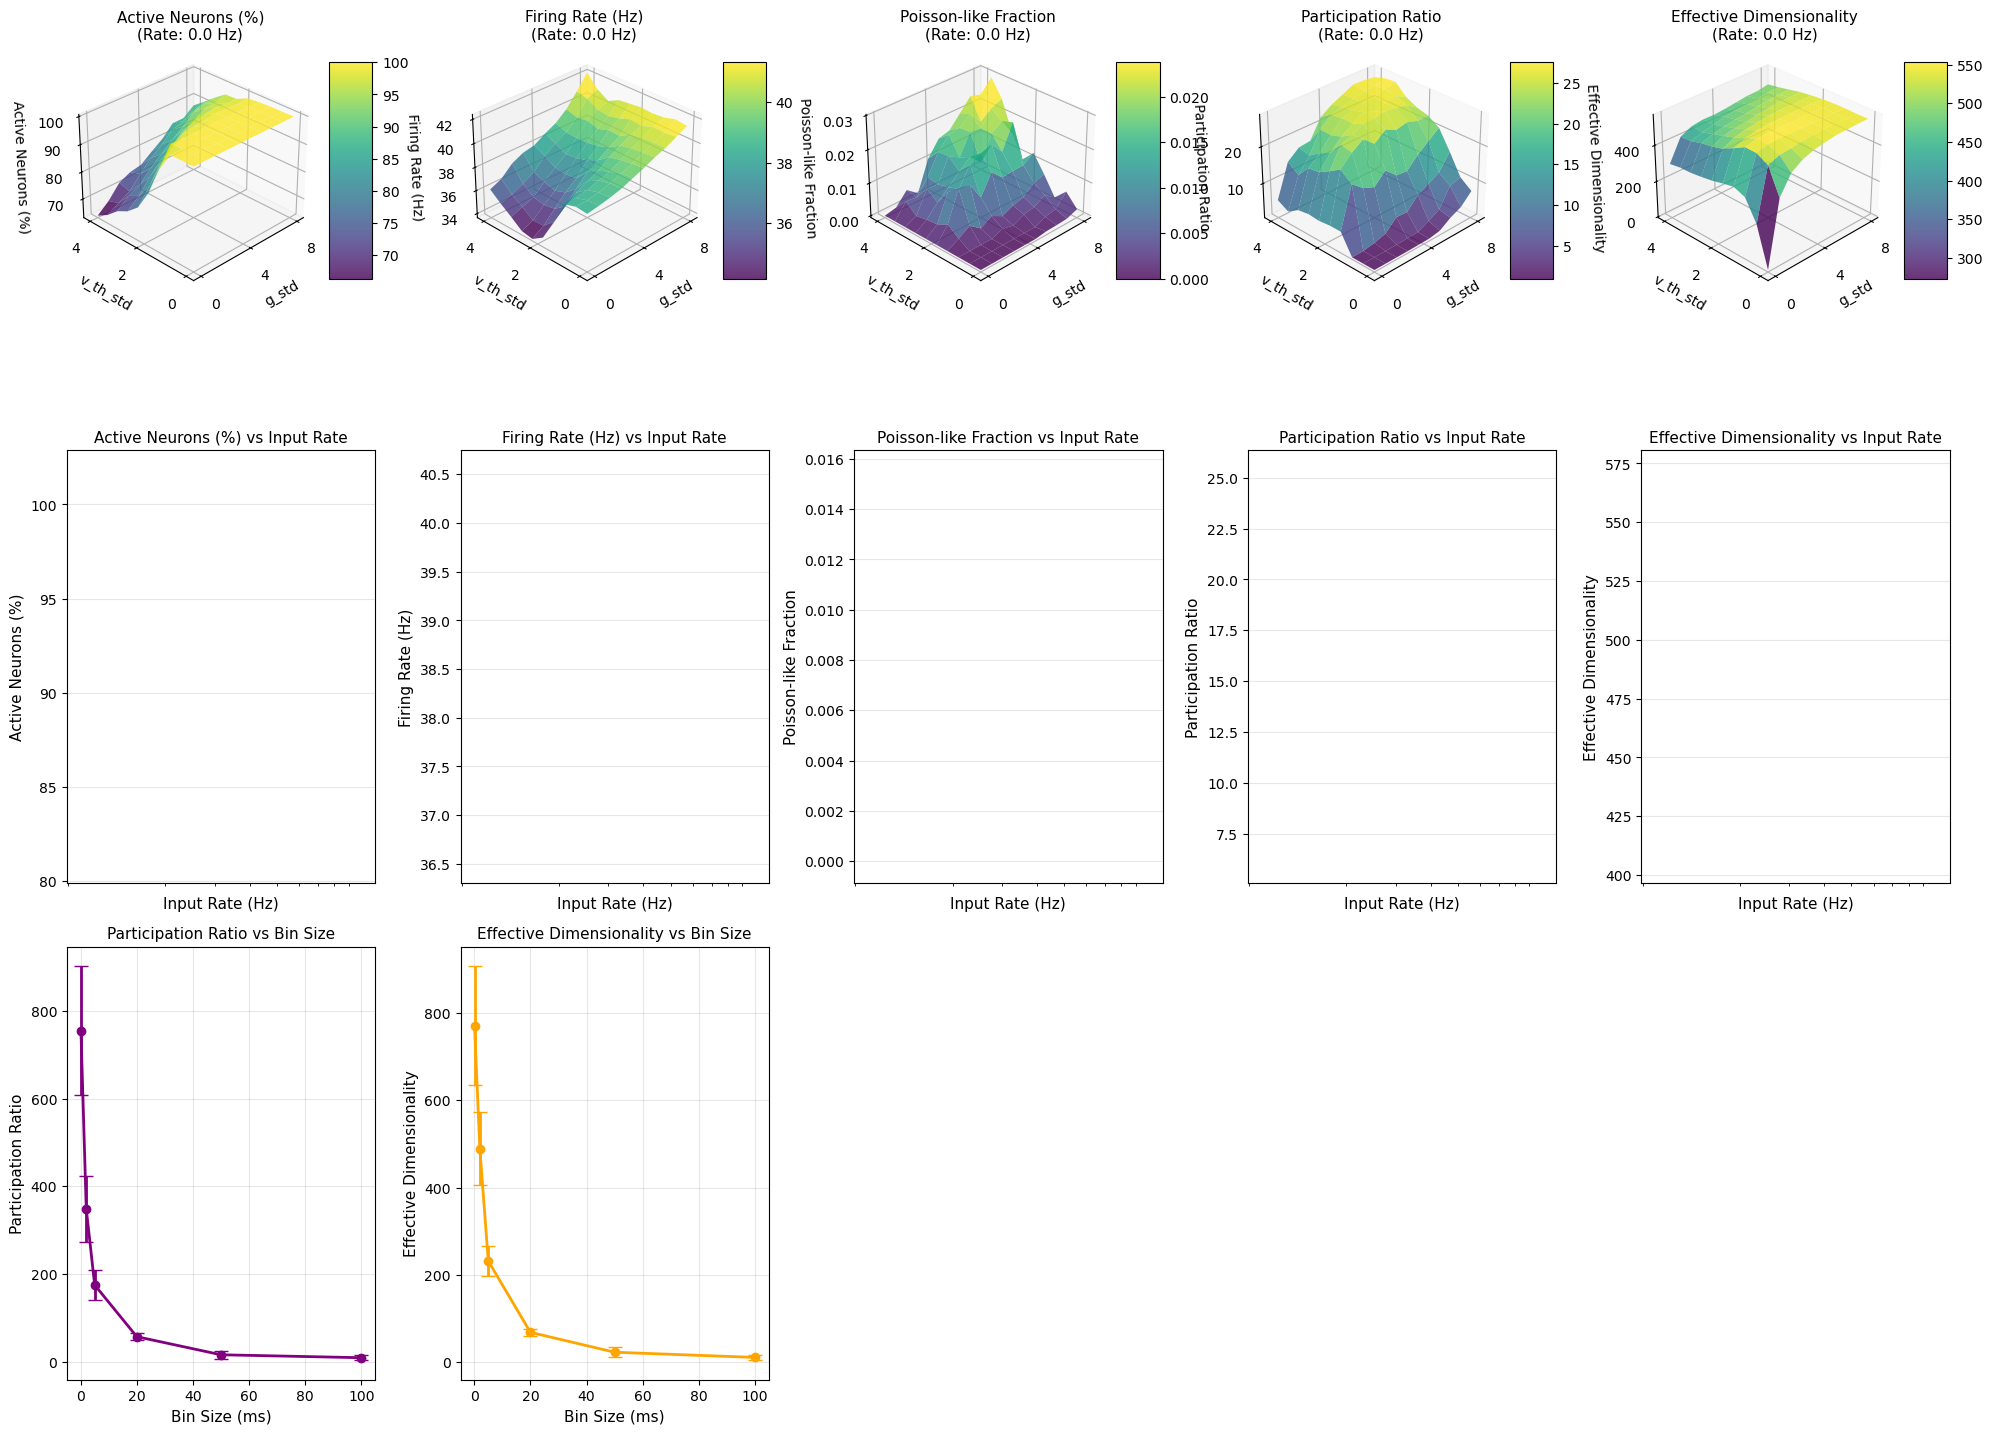

Spontaneous activity plots saved as 'spontaneous_analysis.png'


In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Load results
filename = 'results/data/spontaneous_session_2_immediate.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# Choose specific input rate for 3D plots
selected_rate = input_rates[len(input_rates)//2]  # Middle rate, adjust as needed
selected_rate = input_rates[0]
print(f"Plotting 3D surfaces for input rate: {selected_rate} Hz")

# Create meshgrid
V_TH, G = np.meshgrid(v_th_stds, g_stds)

# Function to extract data for specific input rate
def get_data_grid(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for specific input rate"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate):
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates):
    """Average metric across all v_th_std and g_std for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# Function to get dimensionality across bin sizes
def get_dimensionality_vs_binsize(results, metric_prefix):
    """Average dimensionality across all parameters for each bin size"""
    bin_sizes = [0.1, 2.0, 5.0, 20.0, 50.0, 100.0]
    means = []
    stds = []
    
    for bin_size in bin_sizes:
        metric_name = f'{metric_prefix}_bin_{bin_size}ms_mean'
        values = [r[metric_name] for r in results if not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return bin_sizes, np.array(means), np.array(stds)

# ==================== PLOTTING ====================

fig = plt.figure(figsize=(20, 15))
axs = []

# Row 1: 3D surface plots for selected input rate
metrics_3d = [
    ('percent_active_mean', 'Active Neurons (%)'),
    ('mean_firing_rate_mean', 'Firing Rate (Hz)'),
    ('poisson_isi_fraction_mean', 'Poisson-like Fraction'),
    ('participation_ratio_bin_50.0ms_mean', 'Participation Ratio'),
    ('effective_dimensionality_bin_2.0ms_mean', 'Effective Dimensionality')
]

for idx, (metric, title) in enumerate(metrics_3d, 1):
    ax = fig.add_subplot(3, 5, idx, projection='3d')
    axs.append(ax)
    
    Z = get_data_grid(results, metric, selected_rate, v_th_stds, g_stds)
    
    surf = ax.plot_surface(G, V_TH, Z, cmap=cm.viridis, alpha=0.8)
    
    # Set view angle so origin corner is at lowest values
    ax.view_init(elev=30, azim=225)  # Adjust angles as needed
    
    ax.set_ylabel('v_th_std', fontsize=10)
    ax.set_xlabel('g_std', fontsize=10)
    ax.set_zlabel(title, fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Row 2: 2D plots as function of input rate (averaged across v_th_std and g_std)
for idx, (metric, title) in enumerate(metrics_3d, 6):
    ax = fig.add_subplot(3, 5, idx)
    axs.append(ax)
    
    means, stds = get_rate_dependence(results, metric, input_rates)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    xticks_to_show = input_rates[1::2]
    ax.set_xticks(xticks_to_show, labels=[f"{x:.1f}" for x in xticks_to_show])  # Use .1f for 1 decimal, adjust as needed


axs = np.array(axs).reshape(2,-1)

# axs[0,0].set_zlim((98.8,100))
# axs[0,0].set_zticks((99,100))

for i in range(5):
    axs[0,i].set_xticks([0,4,8])
    axs[0,i].set_yticks([0,2,4])

# Row 3: Dimensionality vs bin size
# Column 1: Participation ratio
ax = fig.add_subplot(3, 5, 11)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'participation_ratio')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='purple')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Participation Ratio', fontsize=11)
ax.set_title('Participation Ratio vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Column 2: Effective dimensionality
ax = fig.add_subplot(3, 5, 12)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'effective_dimensionality')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='orange')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Effective Dimensionality', fontsize=11)
ax.set_title('Effective Dimensionality vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spontaneous_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spontaneous activity plots saved as 'spontaneous_analysis.png'")

Plotting 3D surfaces for input rate: 0.0 Hz


/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/3060995662.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/3060995662.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/3060995662.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/3060995662.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_1117/3060995662.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


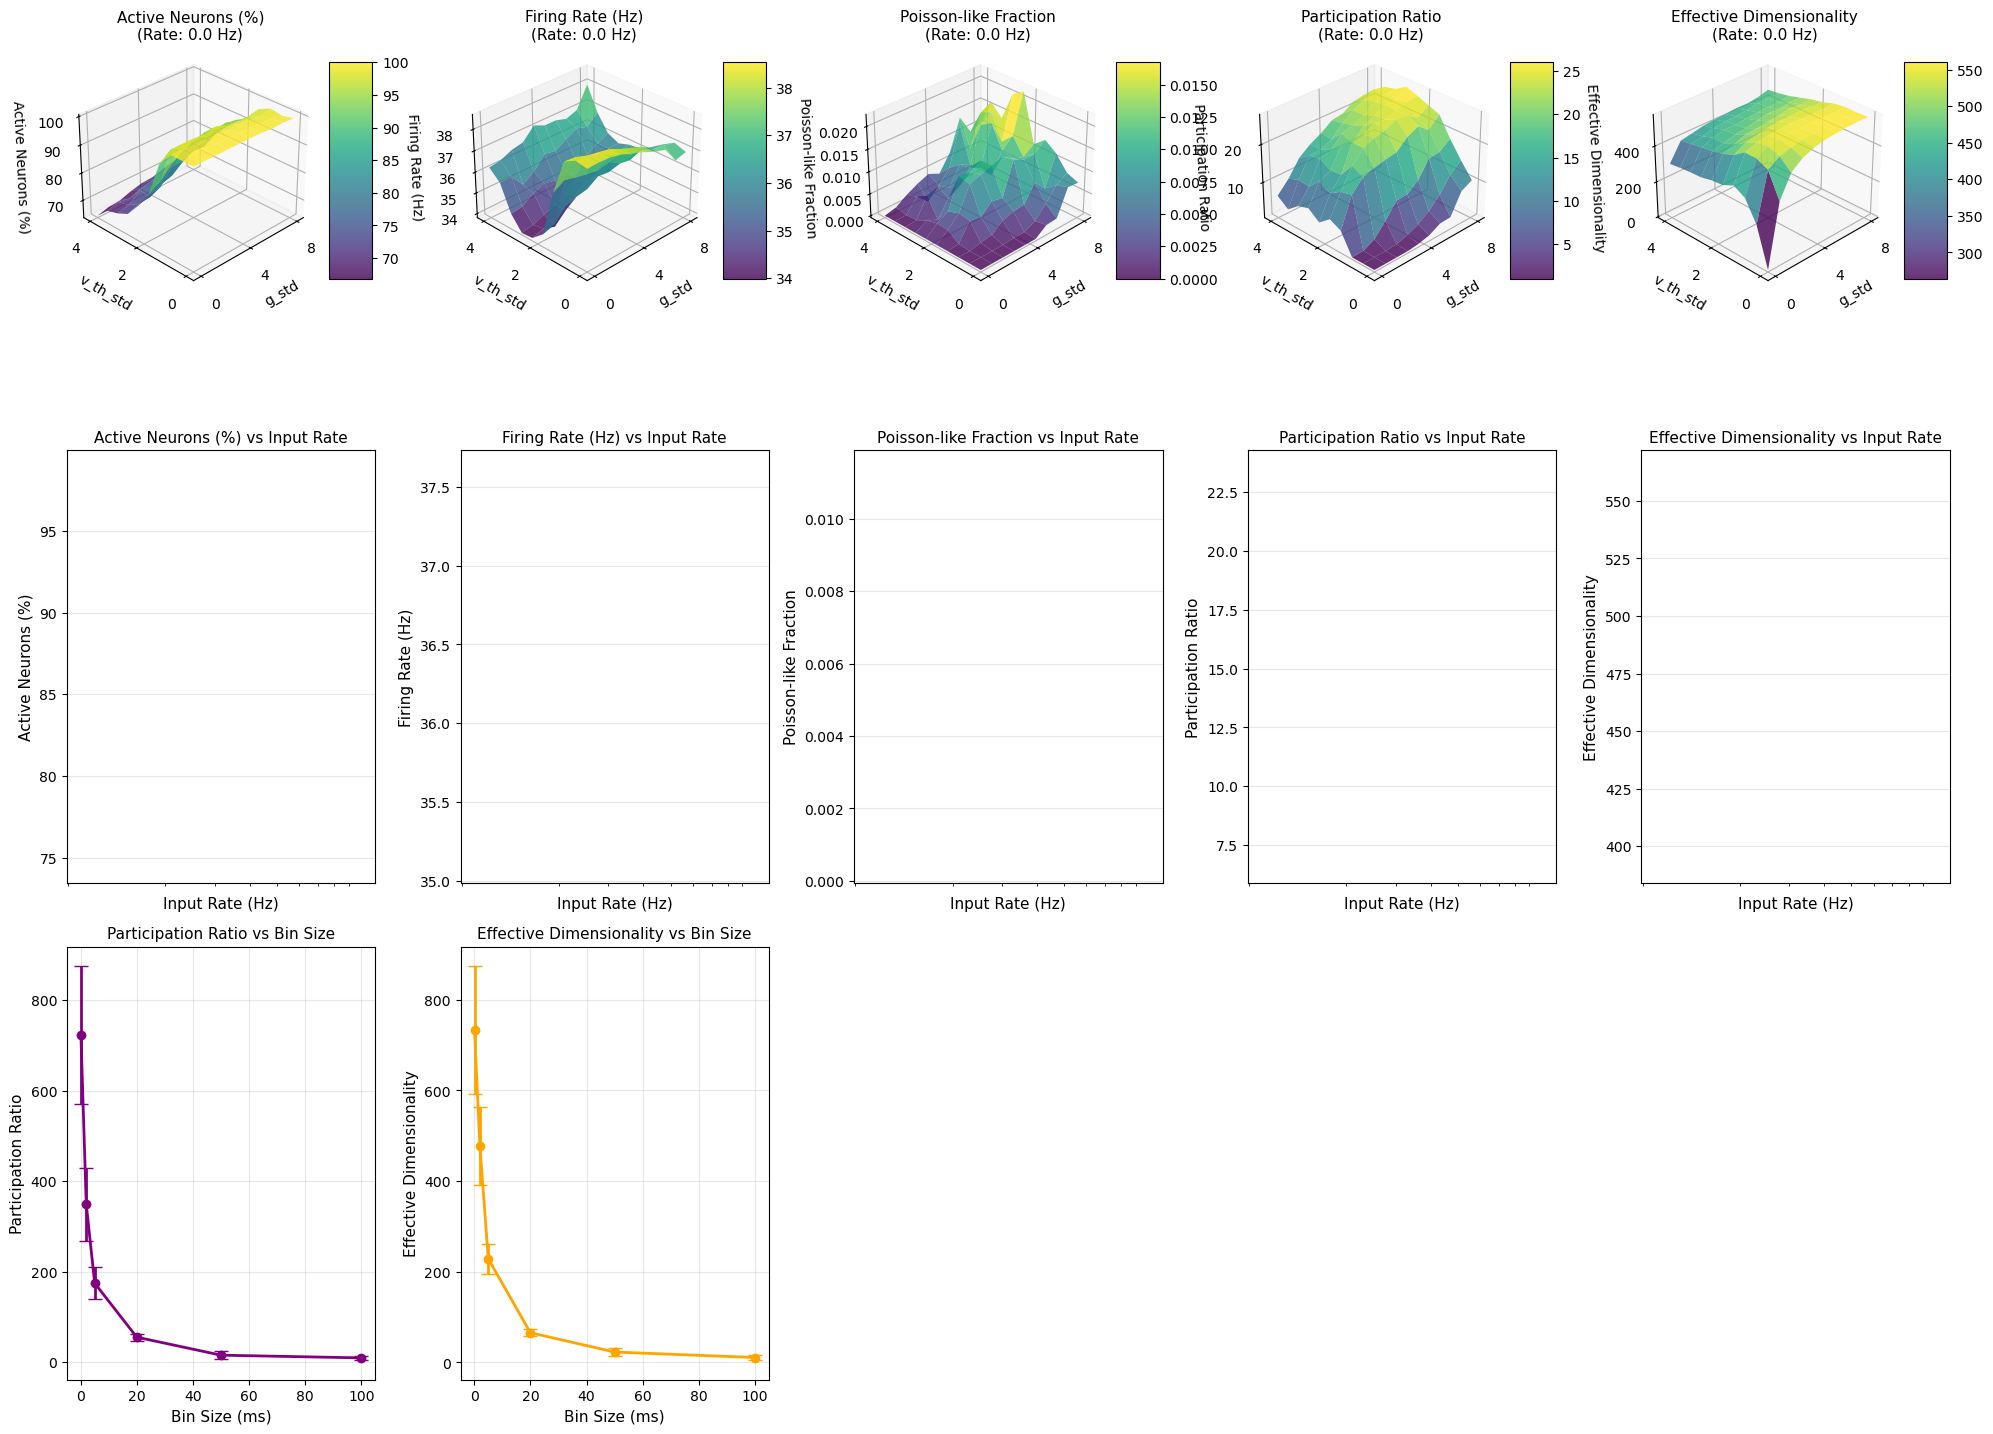

Spontaneous activity plots saved as 'spontaneous_analysis.png'


In [29]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Load results
filename = 'results/data/spontaneous_session_2_dynamic.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# Choose specific input rate for 3D plots
selected_rate = input_rates[len(input_rates)//2]  # Middle rate, adjust as needed
selected_rate = input_rates[0]
print(f"Plotting 3D surfaces for input rate: {selected_rate} Hz")

# Create meshgrid
V_TH, G = np.meshgrid(v_th_stds, g_stds)

# Function to extract data for specific input rate
def get_data_grid(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for specific input rate"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate):
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates):
    """Average metric across all v_th_std and g_std for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# Function to get dimensionality across bin sizes
def get_dimensionality_vs_binsize(results, metric_prefix):
    """Average dimensionality across all parameters for each bin size"""
    bin_sizes = [0.1, 2.0, 5.0, 20.0, 50.0, 100.0]
    means = []
    stds = []
    
    for bin_size in bin_sizes:
        metric_name = f'{metric_prefix}_bin_{bin_size}ms_mean'
        values = [r[metric_name] for r in results if not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return bin_sizes, np.array(means), np.array(stds)

# ==================== PLOTTING ====================

fig = plt.figure(figsize=(20, 15))
axs = []

# Row 1: 3D surface plots for selected input rate
metrics_3d = [
    ('percent_active_mean', 'Active Neurons (%)'),
    ('mean_firing_rate_mean', 'Firing Rate (Hz)'),
    ('poisson_isi_fraction_mean', 'Poisson-like Fraction'),
    ('participation_ratio_bin_50.0ms_mean', 'Participation Ratio'),
    ('effective_dimensionality_bin_2.0ms_mean', 'Effective Dimensionality')
]

for idx, (metric, title) in enumerate(metrics_3d, 1):
    ax = fig.add_subplot(3, 5, idx, projection='3d')
    axs.append(ax)
    
    Z = get_data_grid(results, metric, selected_rate, v_th_stds, g_stds)
    
    surf = ax.plot_surface(G, V_TH, Z, cmap=cm.viridis, alpha=0.8)
    
    # Set view angle so origin corner is at lowest values
    ax.view_init(elev=30, azim=225)  # Adjust angles as needed
    
    ax.set_ylabel('v_th_std', fontsize=10)
    ax.set_xlabel('g_std', fontsize=10)
    ax.set_zlabel(title, fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Row 2: 2D plots as function of input rate (averaged across v_th_std and g_std)
for idx, (metric, title) in enumerate(metrics_3d, 6):
    ax = fig.add_subplot(3, 5, idx)
    axs.append(ax)
    
    means, stds = get_rate_dependence(results, metric, input_rates)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    xticks_to_show = input_rates[1::2]
    ax.set_xticks(xticks_to_show, labels=[f"{x:.1f}" for x in xticks_to_show])  # Use .1f for 1 decimal, adjust as needed


axs = np.array(axs).reshape(2,-1)

# axs[0,0].set_zlim((98.8,100))
# axs[0,0].set_zticks((99,100))

for i in range(5):
    axs[0,i].set_xticks([0,4,8])
    axs[0,i].set_yticks([0,2,4])

# Row 3: Dimensionality vs bin size
# Column 1: Participation ratio
ax = fig.add_subplot(3, 5, 11)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'participation_ratio')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='purple')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Participation Ratio', fontsize=11)
ax.set_title('Participation Ratio vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Column 2: Effective dimensionality
ax = fig.add_subplot(3, 5, 12)
bin_sizes, means, stds = get_dimensionality_vs_binsize(results, 'effective_dimensionality')
ax.errorbar(bin_sizes, means, yerr=stds, fmt='o-', capsize=5, 
            linewidth=2, markersize=6, color='orange')
ax.set_xlabel('Bin Size (ms)', fontsize=11)
ax.set_ylabel('Effective Dimensionality', fontsize=11)
ax.set_title('Effective Dimensionality vs Bin Size', fontsize=11)
# ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spontaneous_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spontaneous activity plots saved as 'spontaneous_analysis.png'")

In [60]:
input_rates

[0.1,
 0.19947365987750282,
 0.3978974098492567,
 0.7937005259840996,
 1.5832234876474738,
 3.15811383485066,
 6.2996052494743635,
 12.566053148961805,
 25.065966118386303,
 50.0]

In [62]:
np.geomspace(0.1,50,10)

array([ 0.1       ,  0.19947366,  0.39789741,  0.79370053,  1.58322349,
        3.15811383,  6.29960525, 12.56605315, 25.06596612, 50.        ])

In [609]:
np.geomspace(1,50,10)

array([ 1.        ,  1.5444521 ,  2.3853323 ,  3.6840315 ,  5.6898102 ,
        8.78763934, 13.57208808, 20.96144001, 32.37394014, 50.        ])

In [69]:
import pickle
filename = 'results/data/spontaneous_session_1_dynamic.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)

In [71]:
len(results)

1000

In [113]:
results[0]["effective_dimensionality_bin_2.0ms_mean"], results[-1]["poisson_isi_fraction_values"].mean(), results[-1]["poisson_count_fraction_values"].mean()

(151.5, 0.008799999999999999, 0.8969000000000001)

In [131]:
results[500]["static_input_rate"],results[-1]["mean_cv_isi_mean"],

(3.15811383485066, 1.0393672268670753)

In [147]:
filename = 'results/data/stability_session_1_dynamic.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)
    
results[0].keys()

dict_keys(['session_id', 'v_th_std', 'g_std', 'v_th_distribution', 'static_input_rate', 'synaptic_mode', 'lz_spatial_patterns_values', 'shannon_entropy_symbols_values', 'shannon_entropy_spikes_values', 'unique_patterns_count_values', 'post_pert_symbol_sum_values', 'total_spike_differences_values', 'settling_time_ms_values', 'kistler_delta_2ms_values', 'kistler_delta_5ms_values', 'gamma_window_2ms_values', 'gamma_window_5ms_values', 'lz_spatial_patterns_mean', 'lz_spatial_patterns_std', 'shannon_entropy_symbols_mean', 'shannon_entropy_symbols_std', 'shannon_entropy_spikes_mean', 'shannon_entropy_spikes_std', 'unique_patterns_count_mean', 'unique_patterns_count_std', 'post_pert_symbol_sum_mean', 'post_pert_symbol_sum_std', 'total_spike_differences_mean', 'total_spike_differences_std', 'settling_time_ms_mean', 'settling_time_ms_std', 'kistler_delta_2ms_mean', 'kistler_delta_2ms_std', 'kistler_delta_5ms_mean', 'kistler_delta_5ms_std', 'gamma_window_2ms_mean', 'gamma_window_2ms_std', 'gamma

Plotting heatmaps for input rate: 23.811015779522997 Hz


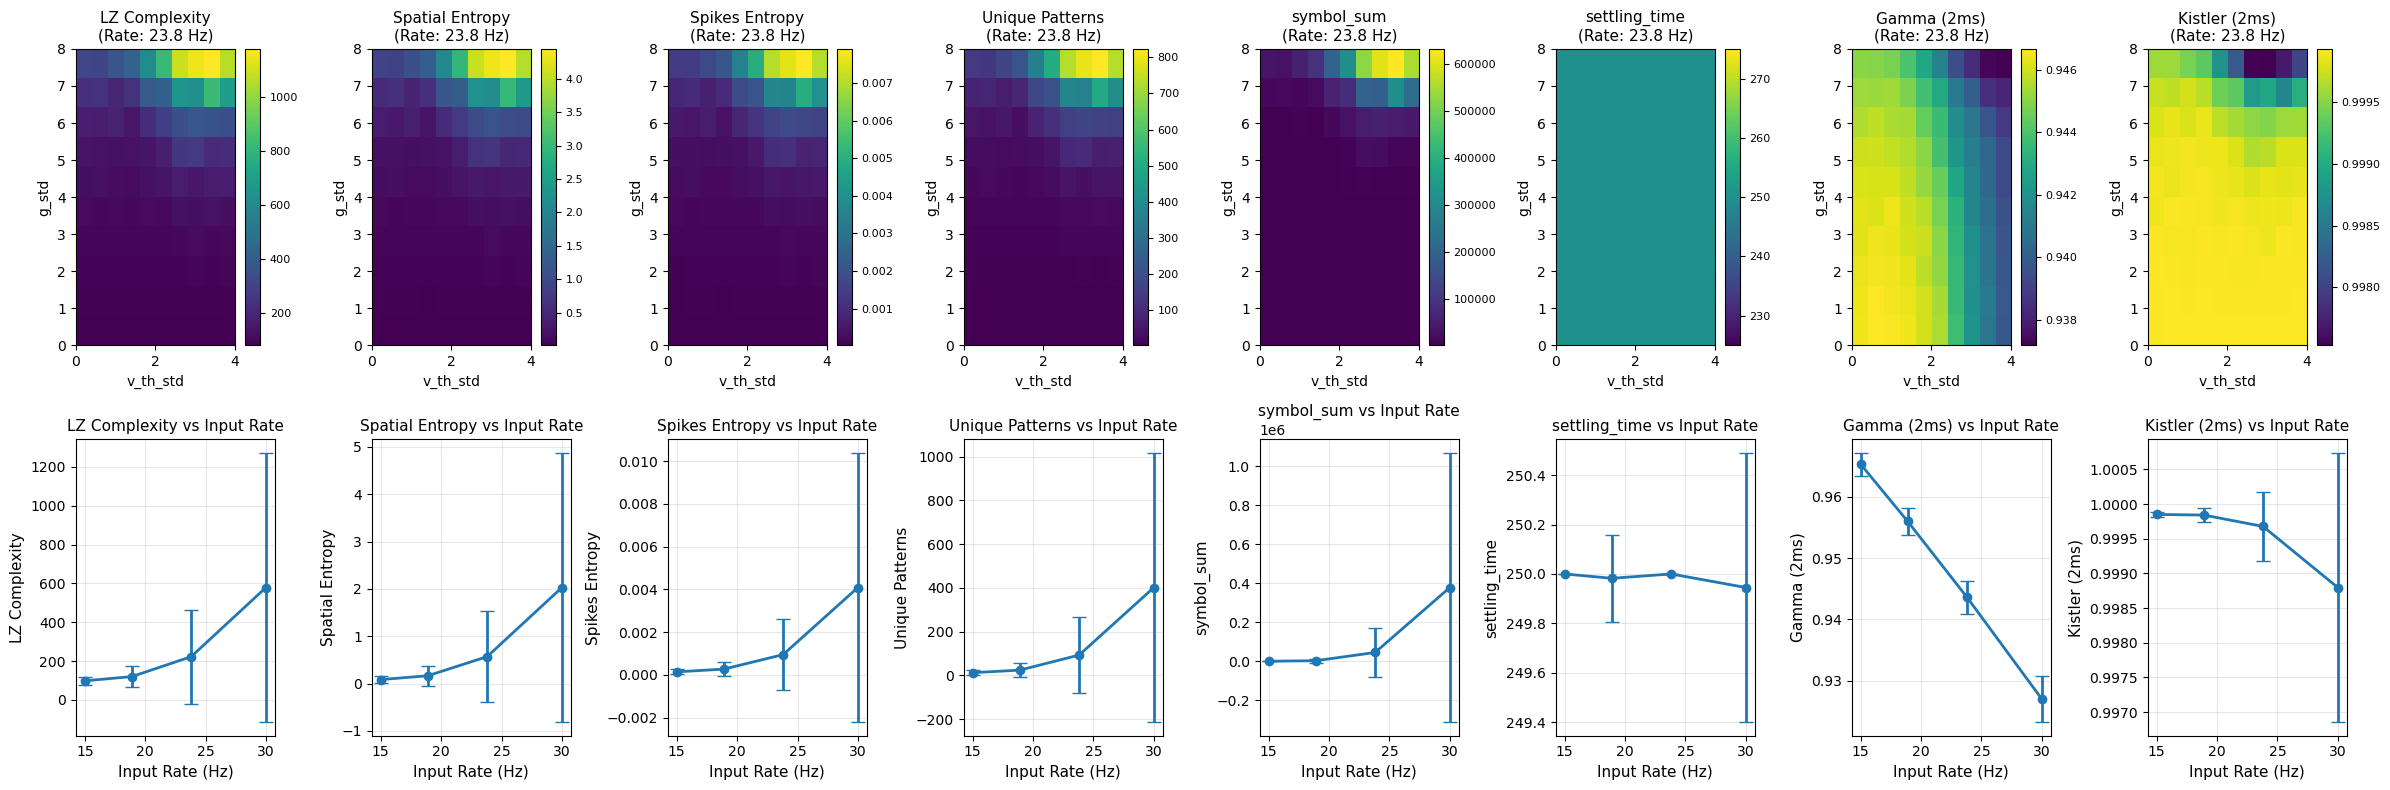

Stability analysis plots saved as 'stability_analysis.png'


In [183]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load results
filename = 'results/data/stability_session_2_immediate.pkl'  # Adjust as needed
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))

input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# Choose specific input rate for heatmaps
selected_rate = input_rates[len(input_rates)//2]  # Middle rate
selected_rate = input_rates[-2]
print(f"Plotting heatmaps for input rate: {selected_rate} Hz")

# Function to create heatmap data
def get_heatmap_data(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for heatmap"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate):
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates):
    """Average metric across all v_th_std and g_std for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# ==================== PLOTTING ====================

fig = plt.figure(figsize=(24, 8))

# Row 1: Heatmaps for selected input rate
metrics_heatmap = [
    ('lz_spatial_patterns_mean', 'LZ Complexity'),
    ('shannon_entropy_symbols_mean', 'Spatial Entropy'),
    ('shannon_entropy_spikes_mean', 'Spikes Entropy'),
    ('unique_patterns_count_mean', 'Unique Patterns'),
    ('post_pert_symbol_sum_mean', 'symbol_sum'),
    ('settling_time_ms_mean', 'settling_time'),
    ('gamma_window_2ms_mean', 'Gamma (2ms)'),
    ('kistler_delta_2ms_mean', 'Kistler (2ms)')
]

for idx, (metric, title) in enumerate(metrics_heatmap, 1):
    ax = fig.add_subplot(2, 8, idx)
    
    data = get_heatmap_data(results, metric, selected_rate, v_th_stds, g_stds)
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='viridis', 
                   extent=[v_th_stds[0], v_th_stds[-1], g_stds[0], g_stds[-1]])
    
    ax.set_xlabel('v_th_std', fontsize=10)
    ax.set_ylabel('g_std', fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Row 2: Line plots as function of input rate
for idx, (metric, title) in enumerate(metrics_heatmap, 9):
    ax = fig.add_subplot(2, 8, idx)
    
    means, stds = get_rate_dependence(results, metric, input_rates)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability analysis plots saved as 'stability_analysis.png'")

Plotting g_std values: [0.8888888888888888, 1.7777777777777777, 2.6666666666666665, 3.5555555555555554, 4.444444444444445, 5.333333333333333, 6.222222222222221, 7.111111111111111, 8.0]
Plotting heatmaps for input rate: 0.0 Hz


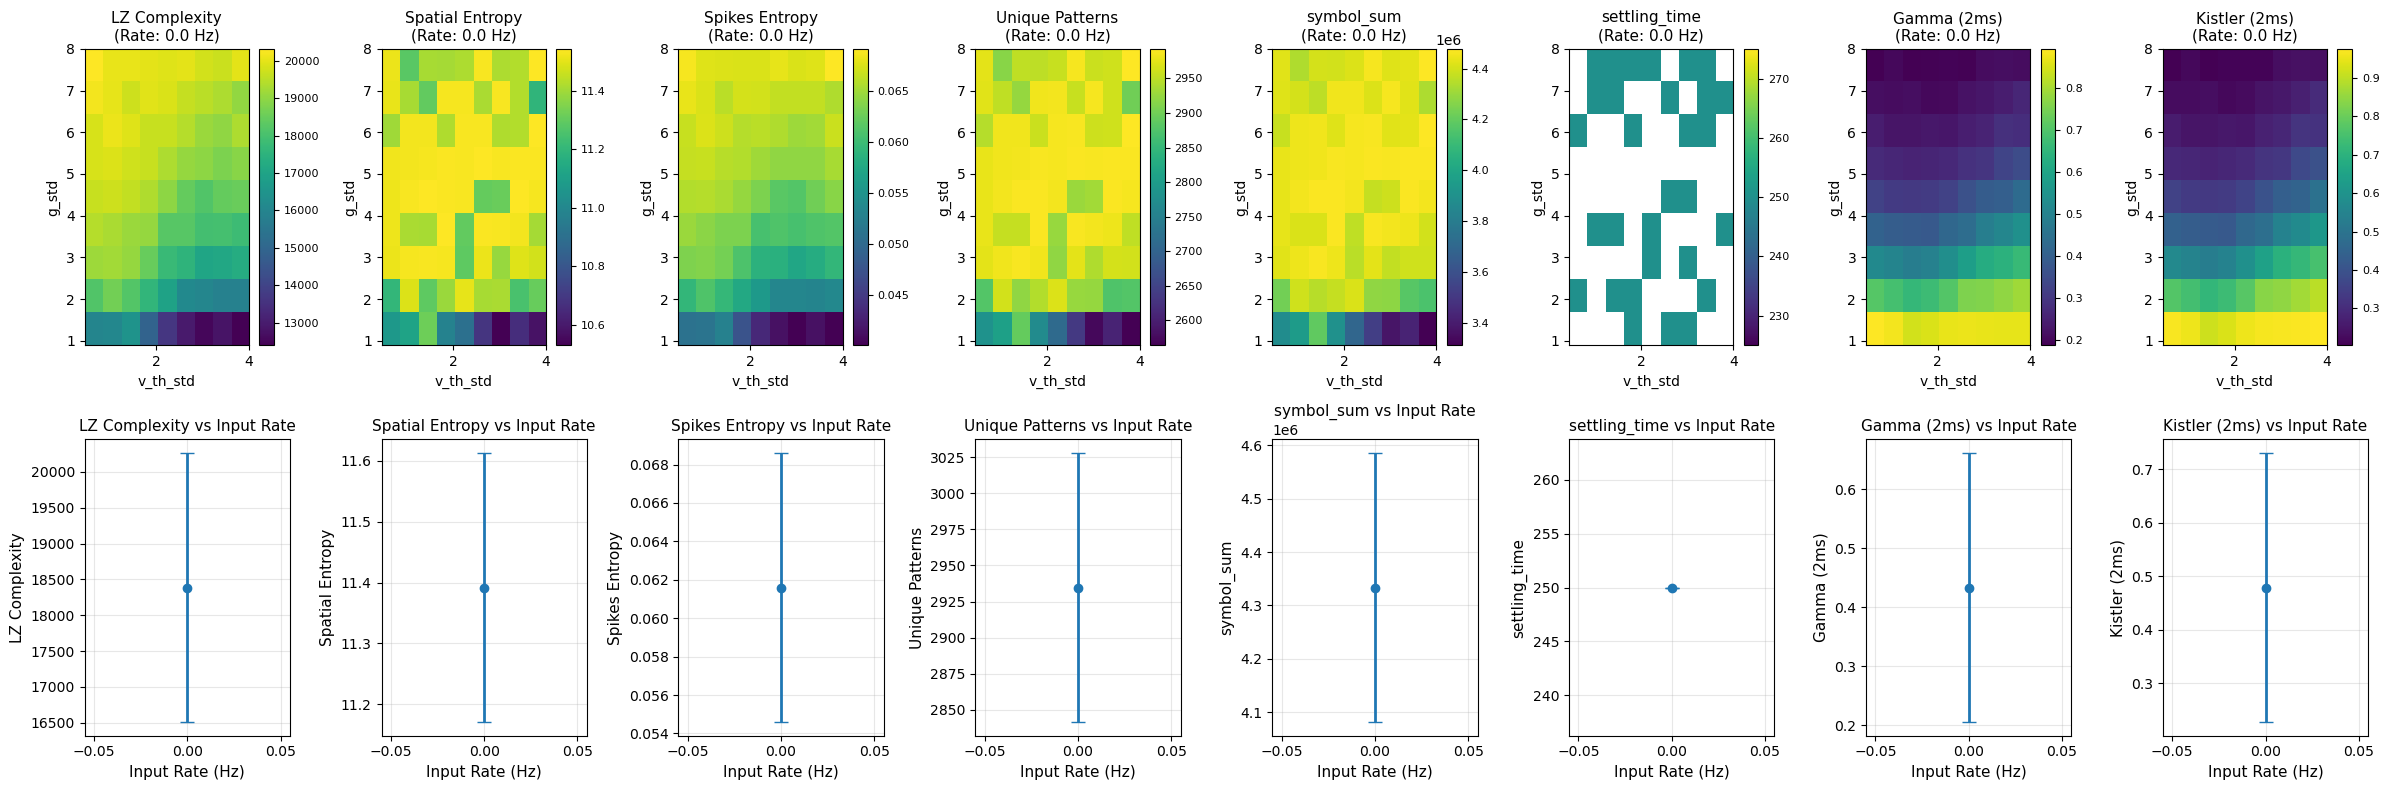

Stability analysis plots saved as 'stability_analysis.png'


In [19]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load results
filename = 'results/data/stability_session_1_immediate_uniform.pkl'
filename = 'results/data/stability_session_2_immediate.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# SET MAX G_STD TO PLOT
max_g_std = 10  # Change this value to limit g_std range
g_stds = [g for g in g_stds if 0<g <= max_g_std]

max_v_th_stds = 10  # Change this value to limit g_std range
v_th_stds = [v for v in v_th_stds if 0<v <= max_v_th_stds]

print(f"Plotting g_std values: {g_stds}")

# Choose specific input rate for heatmaps
selected_rate = input_rates[0]
print(f"Plotting heatmaps for input rate: {selected_rate} Hz")

# Function to create heatmap data
def get_heatmap_data(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for heatmap"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate) and r['g_std'] in g_stds and r['v_th_std'] in v_th_stds:
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates, g_stds):
    """Average metric across all v_th_std and g_std (filtered) for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and r['g_std'] in g_stds
                  and r['v_th_std'] in v_th_stds
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# ==================== PLOTTING ====================
fig = plt.figure(figsize=(24, 8))

# Row 1: Heatmaps for selected input rate
metrics_heatmap = [
    ('lz_spatial_patterns_mean', 'LZ Complexity'),
    ('shannon_entropy_symbols_mean', 'Spatial Entropy'),
    ('shannon_entropy_spikes_mean', 'Spikes Entropy'),
    ('unique_patterns_count_mean', 'Unique Patterns'),
    ('post_pert_symbol_sum_mean', 'symbol_sum'),
    ('settling_time_ms_mean', 'settling_time'),
    ('gamma_window_2ms_mean', 'Gamma (2ms)'),
    ('kistler_delta_2ms_mean', 'Kistler (2ms)')
]

for idx, (metric, title) in enumerate(metrics_heatmap, 1):
    ax = fig.add_subplot(2, 8, idx)
    
    data = get_heatmap_data(results, metric, selected_rate, v_th_stds, g_stds)
    
    # Handle case with single g_std value
    if len(g_stds) == 1:
        extent = [v_th_stds[0], v_th_stds[-1], g_stds[0]-0.05, g_stds[0]+0.05]
    else:
        extent = [v_th_stds[0], v_th_stds[-1], g_stds[0], g_stds[-1]]
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='viridis', 
                   extent=extent)
    
    ax.set_xlabel('v_th_std', fontsize=10)
    ax.set_ylabel('g_std', fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Row 2: Line plots as function of input rate
for idx, (metric, title) in enumerate(metrics_heatmap, 9):
    ax = fig.add_subplot(2, 8, idx)
    
    means, stds = get_rate_dependence(results, metric, input_rates, g_stds)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability analysis plots saved as 'stability_analysis.png'")

Plotting g_std values: [0.8888888888888888, 1.7777777777777777, 2.6666666666666665, 3.5555555555555554, 4.444444444444445, 5.333333333333333, 6.222222222222221, 7.111111111111111, 8.0]
Plotting heatmaps for input rate: 0.0 Hz


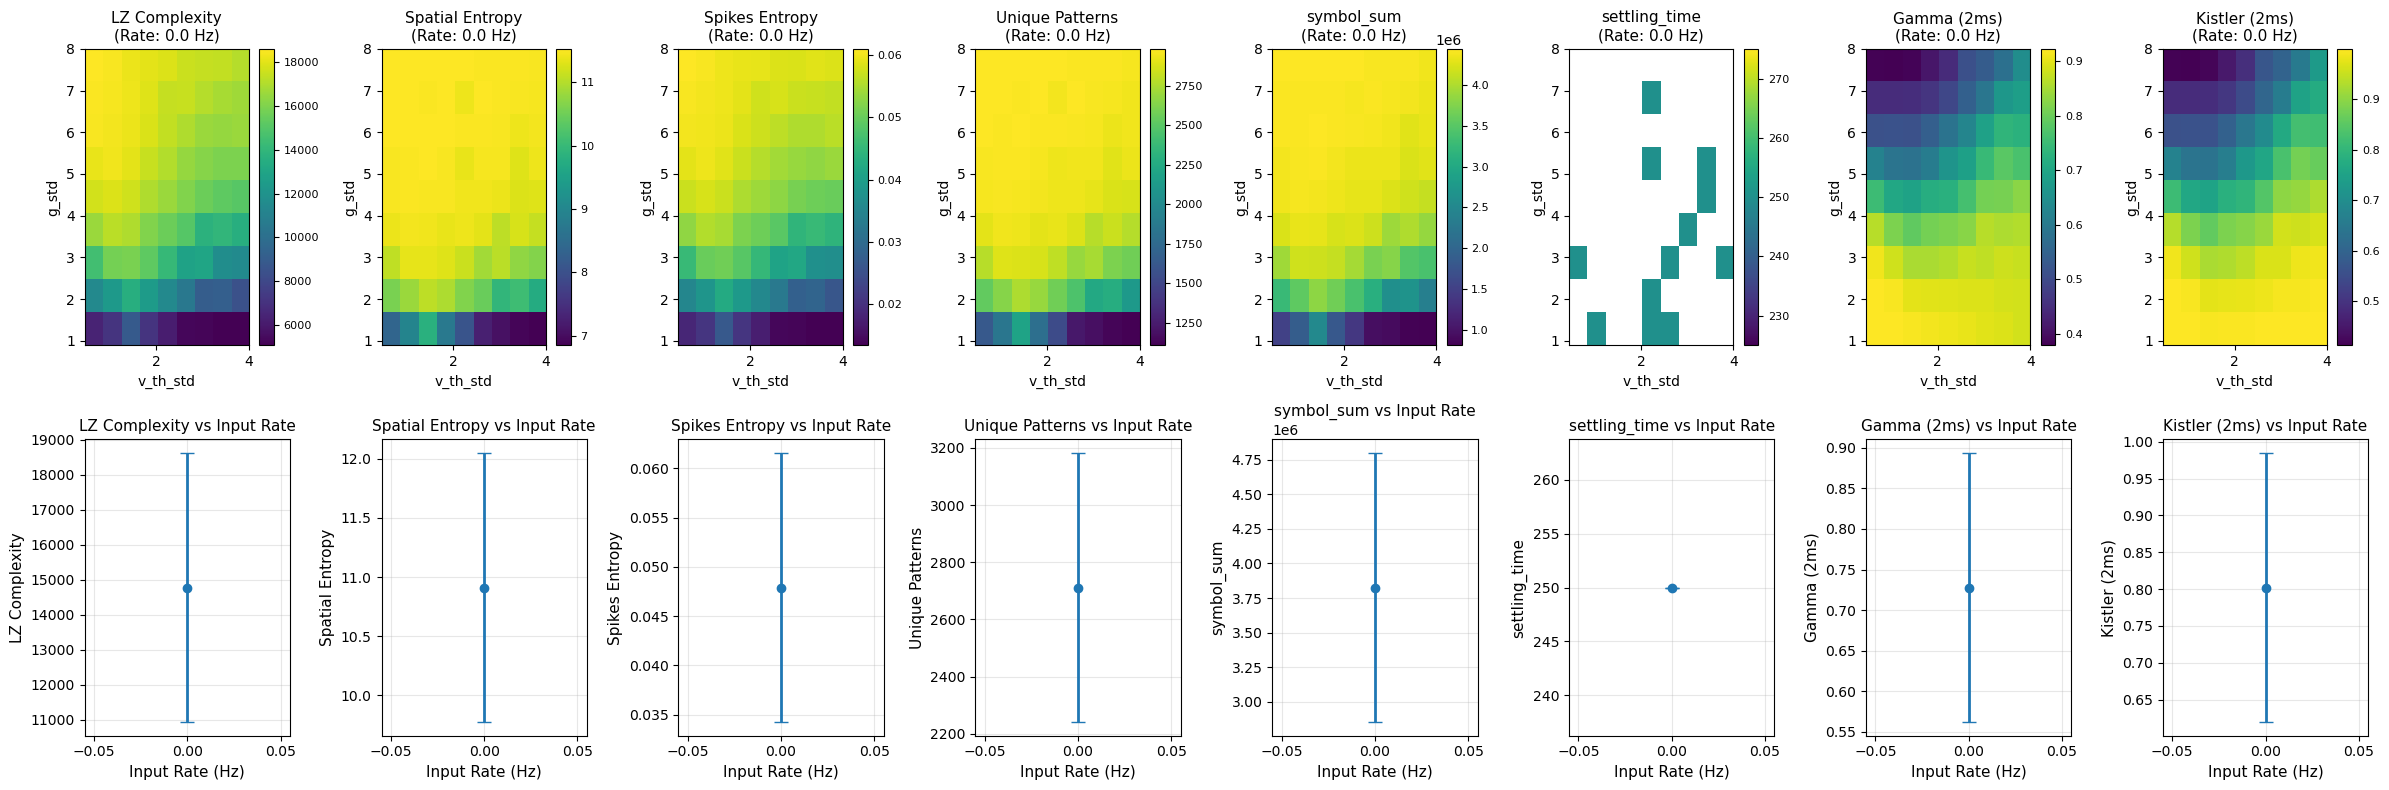

Stability analysis plots saved as 'stability_analysis.png'


In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load results
filename = 'results/data/stability_session_1_immediate_uniform.pkl'
filename = 'results/data/stability_session_2_dynamic.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

# Extract unique parameter values
v_th_stds = sorted(list(set([r['v_th_std'] for r in results])))
g_stds = sorted(list(set([r['g_std'] for r in results])))
input_rates = sorted(list(set([r['static_input_rate'] for r in results])))

# SET MAX G_STD TO PLOT
max_g_std = 10  # Change this value to limit g_std range
g_stds = [g for g in g_stds if 0<g <= max_g_std]

max_v_th_stds = 10  # Change this value to limit g_std range
v_th_stds = [v for v in v_th_stds if 0<v <= max_v_th_stds]

print(f"Plotting g_std values: {g_stds}")

# Choose specific input rate for heatmaps
selected_rate = input_rates[0]
print(f"Plotting heatmaps for input rate: {selected_rate} Hz")

# Function to create heatmap data
def get_heatmap_data(results, metric_name, input_rate, v_th_stds, g_stds):
    """Extract data into 2D grid for heatmap"""
    grid = np.full((len(g_stds), len(v_th_stds)), np.nan)
    
    for r in results:
        if np.isclose(r['static_input_rate'], input_rate) and r['g_std'] in g_stds and r['v_th_std'] in v_th_stds:
            i = g_stds.index(r['g_std'])
            j = v_th_stds.index(r['v_th_std'])
            grid[i, j] = r[metric_name]
    
    return grid

# Function to average across v_th_std and g_std for each input rate
def get_rate_dependence(results, metric_name, input_rates, g_stds):
    """Average metric across all v_th_std and g_std (filtered) for each input rate"""
    means = []
    stds = []
    
    for rate in input_rates:
        values = [r[metric_name] for r in results 
                  if np.isclose(r['static_input_rate'], rate) 
                  and r['g_std'] in g_stds
                  and r['v_th_std'] in v_th_stds
                  and not np.isnan(r[metric_name])]
        means.append(np.mean(values))
        stds.append(np.std(values))
    
    return np.array(means), np.array(stds)

# ==================== PLOTTING ====================
fig = plt.figure(figsize=(24, 8))

# Row 1: Heatmaps for selected input rate
metrics_heatmap = [
    ('lz_spatial_patterns_mean', 'LZ Complexity'),
    ('shannon_entropy_symbols_mean', 'Spatial Entropy'),
    ('shannon_entropy_spikes_mean', 'Spikes Entropy'),
    ('unique_patterns_count_mean', 'Unique Patterns'),
    ('post_pert_symbol_sum_mean', 'symbol_sum'),
    ('settling_time_ms_mean', 'settling_time'),
    ('gamma_window_2ms_mean', 'Gamma (2ms)'),
    ('kistler_delta_2ms_mean', 'Kistler (2ms)')
]

for idx, (metric, title) in enumerate(metrics_heatmap, 1):
    ax = fig.add_subplot(2, 8, idx)
    
    data = get_heatmap_data(results, metric, selected_rate, v_th_stds, g_stds)
    
    # Handle case with single g_std value
    if len(g_stds) == 1:
        extent = [v_th_stds[0], v_th_stds[-1], g_stds[0]-0.05, g_stds[0]+0.05]
    else:
        extent = [v_th_stds[0], v_th_stds[-1], g_stds[0], g_stds[-1]]
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='viridis', 
                   extent=extent)
    
    ax.set_xlabel('v_th_std', fontsize=10)
    ax.set_ylabel('g_std', fontsize=10)
    ax.set_title(f'{title}\n(Rate: {selected_rate:.1f} Hz)', fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Row 2: Line plots as function of input rate
for idx, (metric, title) in enumerate(metrics_heatmap, 9):
    ax = fig.add_subplot(2, 8, idx)
    
    means, stds = get_rate_dependence(results, metric, input_rates, g_stds)
    
    ax.errorbar(input_rates, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=6)
    ax.set_xlabel('Input Rate (Hz)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} vs Input Rate', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability analysis plots saved as 'stability_analysis.png'")

In [164]:
v_th_std = 4
v_th_mean = -55

half_width = v_th_std * np.sqrt(12) / 2
a = v_th_mean - half_width
b = v_th_mean + half_width
spike_thresholds = np.random.uniform(a, b, 1000)
spike_thresholds.min()

-61.92663610802665

In [197]:
np.linspace(0,1,1)

array([0.])

In [166]:
a = v_th_mean - v_th_std * np.sqrt(3)
b = v_th_mean + v_th_std * np.sqrt(3)
v_th = np.random.uniform(a, b, 1000)
v_th.max()

-48.0892266538982

In [190]:
a = np.random.normal(0,10,1000)
print(a.std())
b = 10*a
b.std()

9.740623540229752


97.40623540229751

In [10]:
# Jupyter Notebook: Complete Script

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, 'src')
sys.path.insert(0, 'experiments')
sys.path.insert(0, 'analysis')

from spiking_network import SpikingRNN
from stability_analysis import spikes_to_binary, sort_matrix, lempel_ziv_complexity

%matplotlib inline

# ============= SIMULATION FUNCTION =============
def simulate_perturbation_pair(session_id, v_th_std, g_std, trial_id, static_input_rate, n_neurons=1000):
    """Simulate control and perturbed networks"""
    
    pre_perturbation_time = 50.0
    post_perturbation_time = 300.0
    total_duration = pre_perturbation_time + post_perturbation_time
    perturbation_time = pre_perturbation_time
    
    # Create networks
    net_control = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    net_perturbed = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    
    network_params = {
        'v_th_distribution': 'normal',
        'static_input_strength': 10.0,
        'dynamic_input_strength': 1.0,
        'readout_weight_scale': 1.0
    }
    
    for net in [net_control, net_perturbed]:
        net.initialize_network(session_id, v_th_std, g_std, **network_params)
    
    # Select perturbation neuron
    rng = np.random.default_rng(np.random.SeedSequence([session_id, int(v_th_std*1000), int(g_std*1000)]))
    perturbation_neuron = int(rng.choice(n_neurons, size=1)[0])
    
    # Run simulations
    spikes_control = net_control.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate
    )
    
    spikes_perturbed = net_perturbed.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate,
        perturbation_time, perturbation_neuron
    )
    
    return spikes_control, spikes_perturbed, perturbation_neuron, perturbation_time, total_duration

# ============= RUN SIMULATIONS =============
session_id = 1
trial_id = 1
n_neurons = 1000

combinations = [
    (0.5, 0.5, 20.0),   # v_th_std, g_std, rate
    (0.5, 1.0, 20.0)
]

sim_data = []

for v_th_std, g_std, rate in combinations:
    print(f"Simulating: v_th_std={v_th_std}, g_std={g_std}, rate={rate}Hz")
    
    spikes_c, spikes_p, pert_n, pert_t, total_t = simulate_perturbation_pair(
        session_id, v_th_std, g_std, trial_id, rate, n_neurons
    )
    
    sim_data.append({
        'v_th_std': v_th_std,
        'g_std': g_std,
        'rate': rate,
        'spikes_control': spikes_c,
        'spikes_perturbed': spikes_p,
        'pert_neuron': pert_n,
        'pert_time': pert_t,
        'total_time': total_t
    })

# ============= PLOTTING =============
fig = plt.figure(figsize=(16, 18))

for col_idx, data in enumerate(sim_data):
    
    v_th_std = data['v_th_std']
    g_std = data['g_std']
    rate = data['rate']
    spikes_control = data['spikes_control']
    spikes_perturbed = data['spikes_perturbed']
    pert_neuron = data['pert_neuron']
    pert_time = data['pert_time']
    total_time = data['total_time']
    
    # Compute difference matrix
    bin_size = 2.0
    duration_post = total_time - pert_time
    
    spikes_c_post = [(t - pert_time, n) for t, n in spikes_control if t >= pert_time]
    spikes_p_post = [(t - pert_time, n) for t, n in spikes_perturbed if t >= pert_time]
    
    matrix_c = spikes_to_binary(spikes_c_post, n_neurons, duration_post, bin_size)
    matrix_p = spikes_to_binary(spikes_p_post, n_neurons, duration_post, bin_size)
    
    spike_diff = (matrix_c != matrix_p).astype(int)
    new_col = np.zeros(n_neurons, dtype=int)
    new_col[pert_neuron] = 1
    spike_diff = np.insert(spike_diff, 0, new_col, axis=1)
    
    # LZ complexity
    spike_diff_sorted = sort_matrix(spike_diff)
    lz_comp = lempel_ziv_complexity(spike_diff_sorted)
    
    # Spatial patterns
    spatial_patterns = [tuple(spike_diff[:, t]) for t in range(spike_diff.shape[1])]
    pattern_dict = {}
    symbol_seq = []
    next_id = 0
    for pat in spatial_patterns:
        if pat not in pattern_dict:
            pattern_dict[pat] = next_id
            next_id += 1
        symbol_seq.append(pattern_dict[pat])
    
    time_bins = np.arange(len(symbol_seq)) * bin_size
    
    # Row 1: Raster
    ax1 = plt.subplot(4, 2, 1 + col_idx)
    times_c = [t for t, n in spikes_control if t >= pert_time]
    neurons_c = [n for t, n in spikes_control if t >= pert_time]
    ax1.scatter(times_c, neurons_c, c='red', s=0.5, alpha=0.2, label='Control')
    
    times_p = [t for t, n in spikes_perturbed if t >= pert_time]
    neurons_p = [n for t, n in spikes_perturbed if t >= pert_time]
    ax1.scatter(times_p, neurons_p, c='blue', s=0.5, alpha=0.2, label='Perturbed')
    
    ax1.axvline(pert_time, color='black', linestyle='--', linewidth=2)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Neuron ID')
    ax1.set_title(f'v_th={v_th_std}, g={g_std}, rate={rate}Hz')
    ax1.legend()
    
    # Row 2: Difference matrix
    ax2 = plt.subplot(4, 2, 3 + col_idx)
    im = ax2.imshow(spike_diff, aspect='auto', cmap='binary', interpolation='nearest')
    ax2.set_xlabel('Time bins')
    ax2.set_ylabel('Neuron ID')
    ax2.set_title('Spike Difference Matrix')
    plt.colorbar(im, ax=ax2)
    
    # Row 3: Pattern sequence
    ax3 = plt.subplot(4, 2, 5 + col_idx)
    ax3.plot(time_bins, symbol_seq, '-o', markersize=3)
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Pattern ID')
    ax3.set_title(f'Spatial Patterns (LZ={lz_comp})')
    ax3.grid(True, alpha=0.3)
    
    # Row 4: Pattern histogram
    ax4 = plt.subplot(4, 2, 7 + col_idx)
    pattern_counts = {p: symbol_seq.count(p) for p in set(symbol_seq)}
    ax4.bar(pattern_counts.keys(), pattern_counts.values(), alpha=0.7)
    ax4.set_xlabel('Pattern ID')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Unique Patterns = {len(pattern_counts)}')
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('spatial_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

Simulating: v_th_std=0.5, g_std=0.5, rate=20.0Hz
Simulating: v_th_std=0.5, g_std=1.0, rate=20.0Hz


TypeError: only length-1 arrays can be converted to Python scalars

Simulating: v_th_std=0.0, g_std=0.0, rate=20.0Hz
Simulating: v_th_std=0.0, g_std=4.0, rate=20.0Hz
Simulations complete!


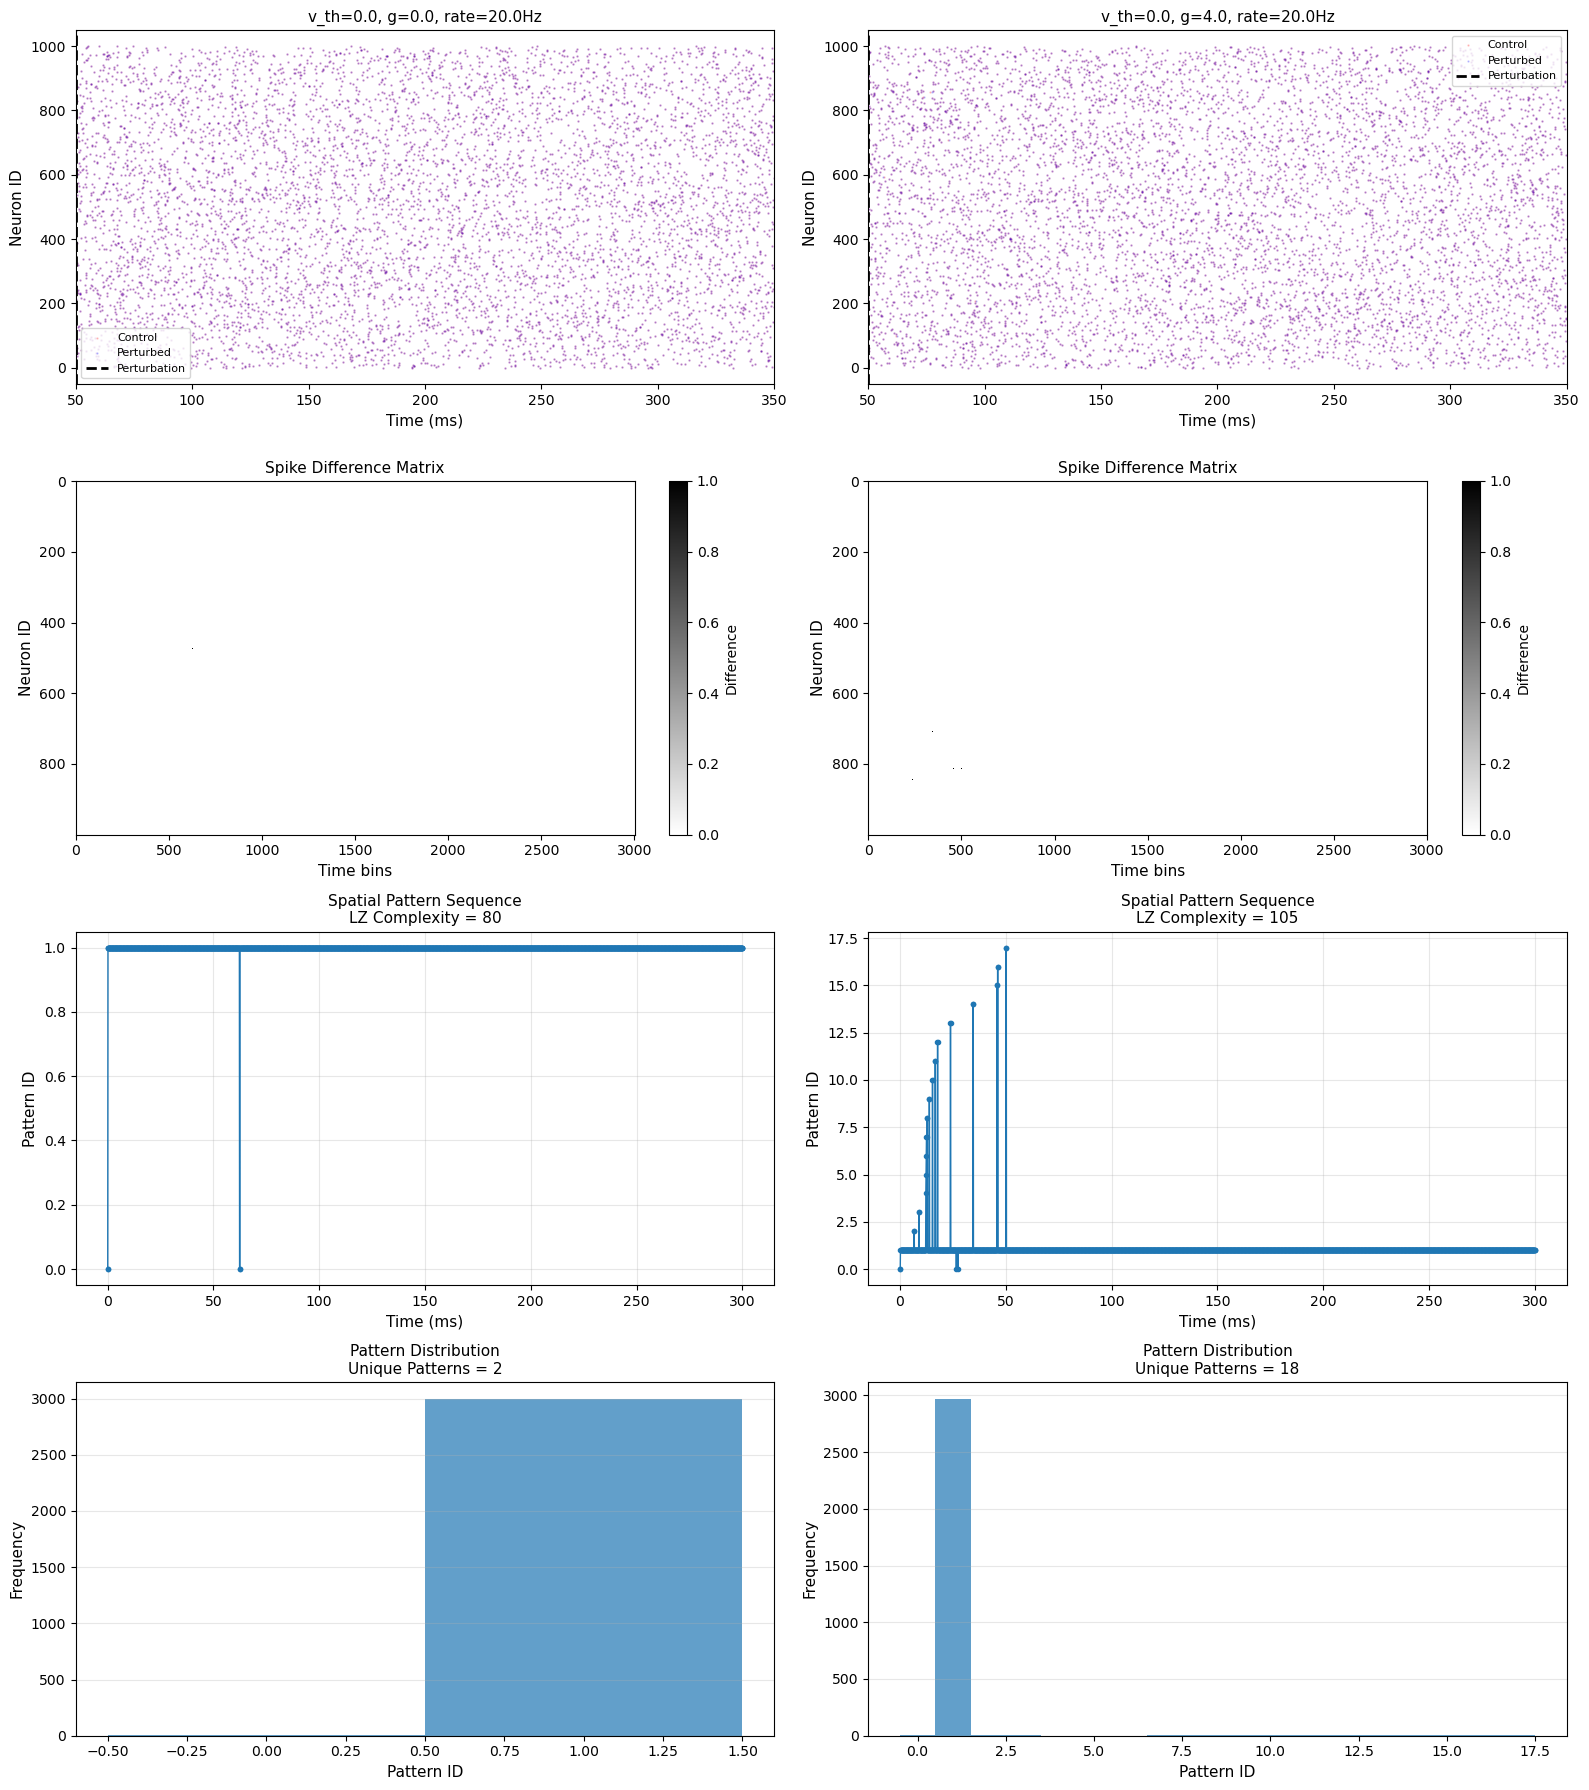

Visualization saved as 'spatial_patterns_comparison.png'


In [33]:
# Jupyter Notebook: Spatial Pattern Visualization

import numpy as np
import matplotlib.pyplot as plt
import sys

# Add paths
sys.path.insert(0, 'src')
sys.path.insert(0, 'analysis')

# Import your functions
from spiking_network import SpikingRNN
from stability_analysis import (
    compute_spike_difference_matrix,
    compute_hamming_distance_from_matrix,
    compute_spatial_pattern_complexity
)

%matplotlib inline

# ============= RUN SIMULATIONS =============
def run_simulation_pair(session_id, v_th_std, g_std, trial_id, static_input_rate, n_neurons=1000):
    """Run control and perturbed simulations"""
    
    # Timing
    pre_perturbation_time = 50.0
    post_perturbation_time = 300.0
    total_duration = pre_perturbation_time + post_perturbation_time
    perturbation_time = pre_perturbation_time
    
    # Create networks
    net_control = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    net_perturbed = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    
    network_params = {
        'v_th_distribution': 'uniform',
        'static_input_strength': 10.0,
        'dynamic_input_strength': 1.0,
        'readout_weight_scale': 1.0
    }
    
    # Initialize with same structure
    for net in [net_control, net_perturbed]:
        net.initialize_network(session_id, v_th_std, g_std, **network_params)
    
    # Select perturbation neuron
    rng = np.random.default_rng(np.random.SeedSequence([session_id, int(v_th_std*1000), int(g_std*1000)]))
    perturbation_neuron = int(rng.choice(n_neurons, size=1)[0])
    
    # Run simulations
    spikes_control = net_control.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate
    )
    
    spikes_perturbed = net_perturbed.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate,
        perturbation_time, perturbation_neuron
    )
    
    return {
        'spikes_control': spikes_control,
        'spikes_perturbed': spikes_perturbed,
        'perturbation_neuron': perturbation_neuron,
        'perturbation_time': perturbation_time,
        'total_duration': total_duration
    }

# Parameters
session_id = 1
trial_id = 1
n_neurons = 1000

combinations = [
    {'v_th_std': 0.0, 'g_std': 0.0, 'rate': 20.0},
    {'v_th_std': 0.0, 'g_std': 4.0, 'rate': 20.0}
]

# Run simulations
sim_results = []
for combo in combinations:
    print(f"Simulating: v_th_std={combo['v_th_std']}, g_std={combo['g_std']}, rate={combo['rate']}Hz")
    result = run_simulation_pair(
        session_id, combo['v_th_std'], combo['g_std'], trial_id, combo['rate'], n_neurons
    )
    result['params'] = combo
    sim_results.append(result)

print("Simulations complete!")

# ============= PLOTTING =============
fig = plt.figure(figsize=(16, 18))

for col_idx, sim in enumerate(sim_results):
    
    params = sim['params']
    spikes_control = sim['spikes_control']
    spikes_perturbed = sim['spikes_perturbed']
    pert_neuron = sim['perturbation_neuron']
    pert_time = sim['perturbation_time']
    total_time = sim['total_duration']
    
    # Use your function to compute spike difference matrix
    spike_diff, total_differences = compute_spike_difference_matrix(
        spikes_control, spikes_perturbed, n_neurons,
        pert_time, total_time, pert_neuron, bin_size=0.1
    )
    
    # Use your function for spatial pattern analysis
    spatial_results = compute_spatial_pattern_complexity(spike_diff)
    lz_comp = spatial_results['lz_spatial_patterns']
    unique_patterns = spatial_results['unique_patterns']
    
    # Extract pattern sequence for plotting
    spatial_patterns = [tuple(spike_diff[:, t]) for t in range(spike_diff.shape[1])]
    pattern_dict = {}
    symbol_seq = []
    next_id = 0
    for pat in spatial_patterns:
        if pat not in pattern_dict:
            pattern_dict[pat] = next_id
            next_id += 1
        symbol_seq.append(pattern_dict[pat])
    
    time_bins = np.arange(len(symbol_seq)) * 0.1  # bin_size = 2.0
    
    # Row 1: Raster plot (superimposed)
    ax1 = plt.subplot(4, 2, 1 + col_idx)
    
    times_c = [t for t, n in spikes_control if t >= pert_time]
    neurons_c = [n for t, n in spikes_control if t >= pert_time]
    ax1.scatter(times_c, neurons_c, c='red', s=0.5, alpha=0.2, label='Control')
    
    times_p = [t for t, n in spikes_perturbed if t >= pert_time]
    neurons_p = [n for t, n in spikes_perturbed if t >= pert_time]
    ax1.scatter(times_p, neurons_p, c='blue', s=0.5, alpha=0.2, label='Perturbed')
    
    ax1.axvline(pert_time, color='black', linestyle='--', linewidth=2, label='Perturbation')
    ax1.set_xlabel('Time (ms)', fontsize=11)
    ax1.set_ylabel('Neuron ID', fontsize=11)
    ax1.set_title(f"v_th={params['v_th_std']}, g={params['g_std']}, rate={params['rate']}Hz", fontsize=11)
    ax1.legend(fontsize=8)
    ax1.set_xlim([pert_time, total_time])
    
    # Row 2: Spike difference matrix
    ax2 = plt.subplot(4, 2, 3 + col_idx)
    im = ax2.imshow(spike_diff, aspect='auto', cmap='binary', interpolation='nearest')
    ax2.set_xlabel('Time bins', fontsize=11)
    ax2.set_ylabel('Neuron ID', fontsize=11)
    ax2.set_title('Spike Difference Matrix', fontsize=11)
    plt.colorbar(im, ax=ax2, label='Difference')
    
    # Row 3: Unique spatial patterns over time
    ax3 = plt.subplot(4, 2, 5 + col_idx)
    ax3.plot(time_bins, symbol_seq, '-o', markersize=3, linewidth=1)
    ax3.set_xlabel('Time (ms)', fontsize=11)
    ax3.set_ylabel('Pattern ID', fontsize=11)
    ax3.set_title(f'Spatial Pattern Sequence\nLZ Complexity = {lz_comp}', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # Row 4: Pattern frequency distribution
    ax4 = plt.subplot(4, 2, 7 + col_idx)
    pattern_counts = {p: symbol_seq.count(p) for p in set(symbol_seq)}
    ax4.bar(pattern_counts.keys(), pattern_counts.values(), width=1.0, alpha=0.7)
    ax4.set_xlabel('Pattern ID', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title(f'Pattern Distribution\nUnique Patterns = {unique_patterns}', fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('spatial_patterns_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'spatial_patterns_comparison.png'")

In [24]:
import numpy as np
import sys

sys.path.insert(0, 'src')
from spiking_network import SpikingRNN

def run_simulation_pair(session_id, v_th_std, g_std, trial_id, static_input_rate, n_neurons=1000):
    """Run control and perturbed simulations"""
    
    # Timing - include pre-perturbation
    pre_perturbation_time = 50.0
    post_perturbation_time = 300.0
    total_duration = pre_perturbation_time + post_perturbation_time
    perturbation_time = pre_perturbation_time
    
    # Create networks
    net_control = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    net_perturbed = SpikingRNN(n_neurons, dt=0.1, synaptic_mode="dynamic")
    
    network_params = {
        'v_th_distribution': 'normal',
        'static_input_strength': 10.0,
        'dynamic_input_strength': 1.0,
        'readout_weight_scale': 1.0
    }
    
    # Initialize with same structure
    for net in [net_control, net_perturbed]:
        net.initialize_network(session_id, v_th_std, g_std, **network_params)
    
    # Select perturbation neuron
    rng = np.random.default_rng(np.random.SeedSequence([session_id, int(v_th_std*1000), int(g_std*1000)]))
    perturbation_neuron = int(rng.choice(n_neurons, size=1)[0])
    
    # Run simulations
    spikes_control = net_control.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate
    )
    
    spikes_perturbed = net_perturbed.simulate_network_dynamics(
        session_id, v_th_std, g_std, trial_id, total_duration, static_input_rate,
        perturbation_time, perturbation_neuron
    )
    
    return {
        'spikes_control': spikes_control,
        'spikes_perturbed': spikes_perturbed,
        'perturbation_neuron': perturbation_neuron,
        'perturbation_time': perturbation_time,
        'total_duration': total_duration,
        'pre_perturbation_time': pre_perturbation_time,
        'n_neurons': n_neurons
    }

# Run simulations
session_id = 7
trial_id = 1
n_neurons = 1000

combinations = [
    {'v_th_std': 0, 'g_std': 1.0, 'rate': 40.0},
    {'v_th_std': 1, 'g_std': 1.0, 'rate': 40.0}
]

sim_results = []
for combo in combinations:
    print(f"Simulating: v_th_std={combo['v_th_std']}, g_std={combo['g_std']}, rate={combo['rate']}Hz")
    result = run_simulation_pair(
        session_id, combo['v_th_std'], combo['g_std'], trial_id, combo['rate'], n_neurons
    )
    result['params'] = combo
    sim_results.append(result)

print(f"Simulations complete! Collected {len(sim_results)} results.")

Simulating: v_th_std=0, g_std=1.0, rate=40.0Hz
Simulating: v_th_std=1, g_std=1.0, rate=40.0Hz
Simulations complete! Collected 2 results.


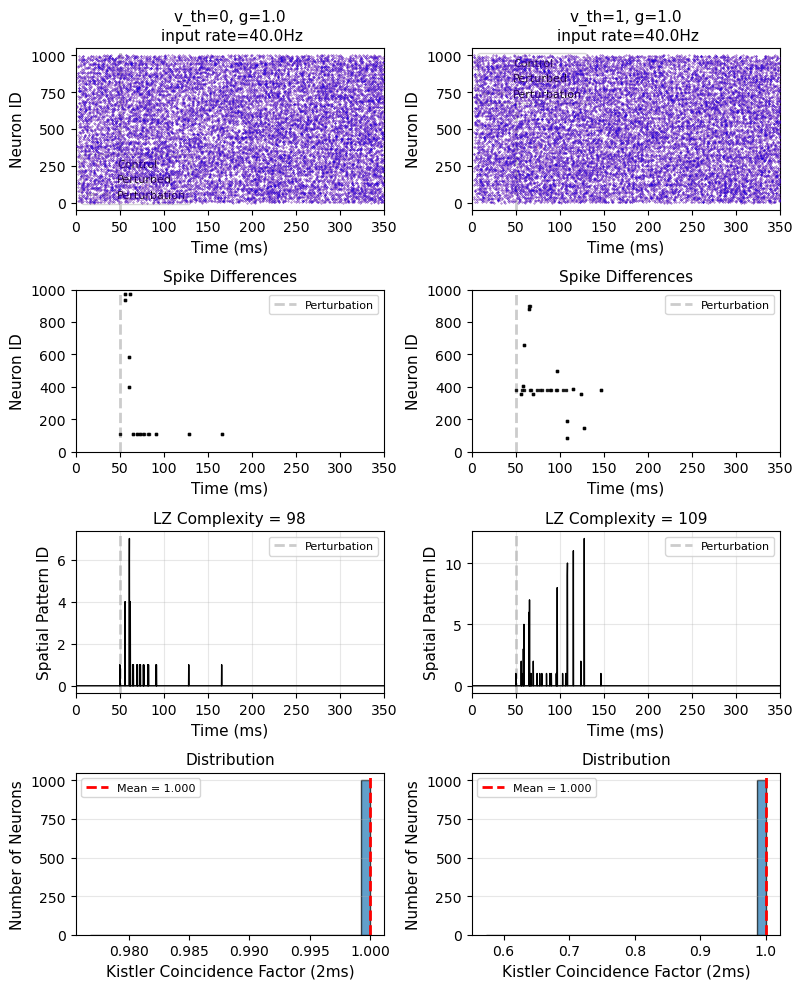

Visualization saved as 'spatial_patterns_comparison_10.png'


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, 'analysis')
from stability_analysis import spikes_to_binary, compute_spatial_pattern_complexity, unified_coincidence_factor

def plot_spatial_patterns(sim_results, bin_size=0.1, save_path='spatial_patterns_comparison_10.png'):
    """
    Plot spatial pattern visualization for simulation results
    
    Args:
        sim_results: List of simulation result dictionaries
        bin_size: Time bin size in ms (default: 0.1)
        save_path: Path to save figure
    """
    
    fig = plt.figure(figsize=(8, 10))
    
    for col_idx, sim in enumerate(sim_results):
        
        params = sim['params']
        spikes_control = sim['spikes_control']
        spikes_perturbed = sim['spikes_perturbed']
        pert_neuron = sim['perturbation_neuron']
        pert_time = sim['perturbation_time']
        total_time = sim['total_duration']
        n_neurons = sim['n_neurons']
        
        # Compute spike difference matrix from FULL spike trains
        matrix_control = spikes_to_binary(spikes_control, n_neurons, total_time, bin_size)
        matrix_perturbed = spikes_to_binary(spikes_perturbed, n_neurons, total_time, bin_size)
        
        # Spike difference matrix (full simulation)
        spike_diff_full = (matrix_control != matrix_perturbed).astype(int)
        
        # Extract post-perturbation part for LZ calculation
        pert_bin = int(pert_time / bin_size)
        spike_diff_post = spike_diff_full[:, pert_bin:]
        
        # LZ complexity on post-perturbation
        spatial_results = compute_spatial_pattern_complexity(spike_diff_post)
        lz_comp = spatial_results['lz_spatial_patterns']
        
        # Extract pattern sequence for FULL difference matrix
        spatial_patterns = [tuple(spike_diff_full[:, t]) for t in range(spike_diff_full.shape[1])]
        pattern_dict = {}
        symbol_seq = []
        next_id = 0
        for pat in spatial_patterns:
            if pat not in pattern_dict:
                pattern_dict[pat] = next_id
                next_id += 1
            symbol_seq.append(pattern_dict[pat])
        
        unique_patterns = len(pattern_dict)
        time_bins = np.arange(len(symbol_seq)) * bin_size
        
        # Row 1: Raster plot
        ax1 = plt.subplot(4, 2, 1 + col_idx)
        
        times_c = [t for t, n in spikes_control]
        neurons_c = [n for t, n in spikes_control]
        ax1.scatter(times_c, neurons_c, c='red', s=0.05, alpha=0.6, label='Control', zorder=10)
        
        times_p = [t for t, n in spikes_perturbed]
        neurons_p = [n for t, n in spikes_perturbed]
        ax1.scatter(times_p, neurons_p, c='blue', s=0.1, alpha=0.6, label='Perturbed', zorder=10)
        
        ax1.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
        ax1.set_xlabel('Time (ms)', fontsize=11)
        ax1.set_ylabel('Neuron ID', fontsize=11)
        ax1.set_title(f"v_th={params['v_th_std']}, g={params['g_std']}\n input rate={params['rate']}Hz", fontsize=11)
        ax1.legend(fontsize=8)
        ax1.set_xlim([0, total_time])
        
        # Row 2: Spike difference matrix
        ax2 = plt.subplot(4, 2, 3 + col_idx)
        
        diff_neurons, diff_bins = np.where(spike_diff_full == 1)
        diff_times_ms = diff_bins * bin_size
        
        ax2.scatter(diff_times_ms, diff_neurons, c='black', s=2, alpha=0.8, marker='s', zorder=10)
        ax2.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
        ax2.set_xlabel('Time (ms)', fontsize=11)
        ax2.set_ylabel('Neuron ID', fontsize=11)
        ax2.set_title('Spike Differences', fontsize=11)
        ax2.set_xlim([0, total_time])
        ax2.set_ylim([0, n_neurons])
        ax2.legend(fontsize=8)
        
        # Row 3: Unique spatial patterns over time
        ax3 = plt.subplot(4, 2, 5 + col_idx)
        ax3.plot(time_bins, symbol_seq, 'k-', linewidth=1, zorder=10)
        ax3.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
        ax3.set_xlabel('Time (ms)', fontsize=11)
        ax3.set_ylabel('Spatial Pattern ID', fontsize=11)
        ax3.set_title(f'LZ Complexity = {lz_comp}', fontsize=11)
        ax3.set_xlim([0, total_time])
        ax3.grid(True, alpha=0.3)
        ax3.legend(fontsize=8)
        
        # Row 4: Kistler coincidence factor distribution
        ax4 = plt.subplot(4, 2, 7 + col_idx)
        
        # Organize spikes by neuron for post-perturbation period
        from collections import defaultdict
        spikes_c_by_neuron = defaultdict(list)
        spikes_p_by_neuron = defaultdict(list)
        
        for t, n in spikes_control:
            if t >= pert_time:
                spikes_c_by_neuron[n].append(t)
        
        for t, n in spikes_perturbed:
            if t >= pert_time:
                spikes_p_by_neuron[n].append(t)
        
        # Compute Kistler for each neuron
        kistler_values = []
        delta = 2.0  # 2ms window
        duration_post = total_time - pert_time
        
        for neuron_id in range(n_neurons):
            train_c = spikes_c_by_neuron[neuron_id]
            train_p = spikes_p_by_neuron[neuron_id]
            
            kistler,_ = unified_coincidence_factor(train_c, train_p, delta, duration_post)
            
            if not np.isnan(kistler):
                kistler_values.append(kistler)
        
        # Plot histogram
        if len(kistler_values) > 0:
            ax4.hist(kistler_values, bins=30, alpha=0.7, edgecolor='black')
            mean_kistler = np.mean(kistler_values)
            ax4.axvline(mean_kistler, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean = {mean_kistler:.3f}')
            ax4.set_xlabel('Kistler Coincidence Factor (2ms)', fontsize=11)
            ax4.set_ylabel('Number of Neurons', fontsize=11)
            ax4.set_title(f'Distribution', fontsize=11)
            ax4.legend(fontsize=8)
            ax4.grid(True, alpha=0.3, axis='y')
        else:
            ax4.text(0.5, 0.5, 'No valid Kistler values', 
                    ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved as '{save_path}'")

# Call plotting function
plot_spatial_patterns(sim_results, bin_size=0.1)

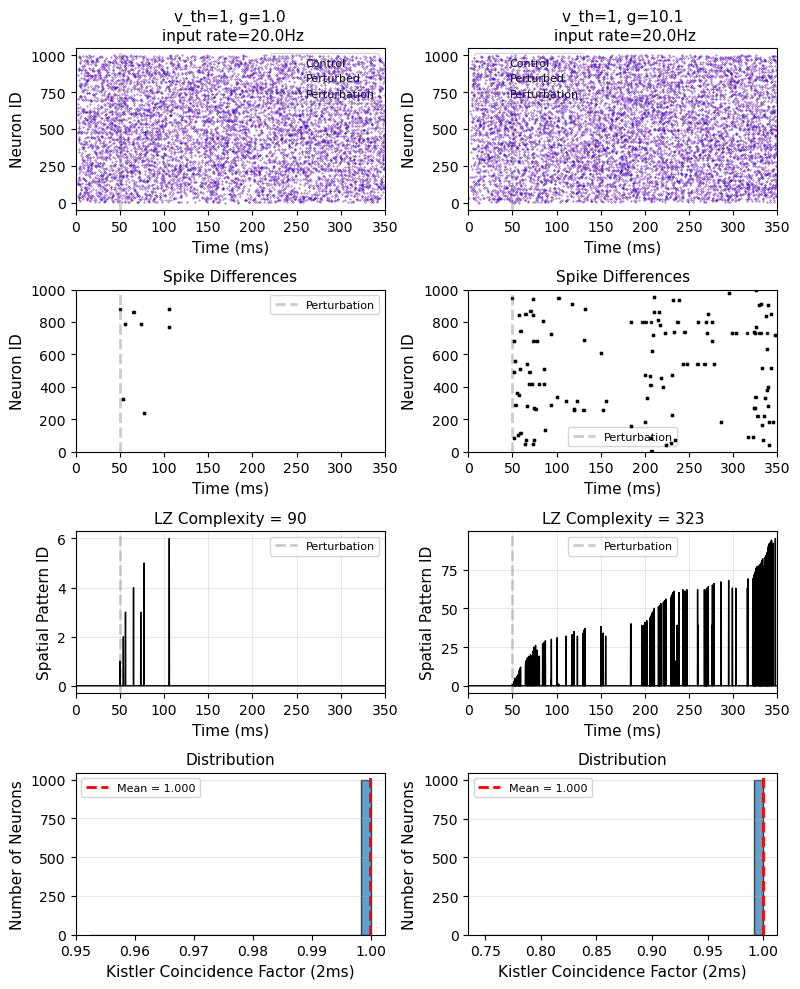

Visualization saved as 'spatial_patterns_comparison_1.png'


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, 'analysis')
from stability_analysis import spikes_to_binary, compute_spatial_pattern_complexity, unified_coincidence_factor

bin_size=0.1
save_path='spatial_patterns_comparison_1.png'

fig = plt.figure(figsize=(8, 10))

for col_idx, sim in enumerate(sim_results):
    
    params = sim['params']
    spikes_control = sim['spikes_control']
    spikes_perturbed = sim['spikes_perturbed']
    pert_neuron = sim['perturbation_neuron']
    pert_time = sim['perturbation_time']
    total_time = sim['total_duration']
    n_neurons = sim['n_neurons']
    
    # Compute spike difference matrix from FULL spike trains
    matrix_control = spikes_to_binary(spikes_control, n_neurons, total_time, bin_size)
    matrix_perturbed = spikes_to_binary(spikes_perturbed, n_neurons, total_time, bin_size)
    
    # Spike difference matrix (full simulation)
    spike_diff_full = (matrix_control != matrix_perturbed).astype(int)
    
    # Extract post-perturbation part for LZ calculation
    pert_bin = int(pert_time / bin_size)
    spike_diff_post = spike_diff_full[:, pert_bin:]
    
    # LZ complexity on post-perturbation
    spatial_results = compute_spatial_pattern_complexity(spike_diff_post)
    lz_comp = spatial_results['lz_spatial_patterns']
    
    # Extract pattern sequence for FULL difference matrix
    spatial_patterns = [tuple(spike_diff_full[:, t]) for t in range(spike_diff_full.shape[1])]
    pattern_dict = {}
    symbol_seq = []
    next_id = 0
    for pat in spatial_patterns:
        if pat not in pattern_dict:
            pattern_dict[pat] = next_id
            next_id += 1
        symbol_seq.append(pattern_dict[pat])
    
    unique_patterns = len(pattern_dict)
    time_bins = np.arange(len(symbol_seq)) * bin_size
    
    # Row 1: Raster plot
    ax1 = plt.subplot(4, 2, 1 + col_idx)
    
    times_c = [t for t, n in spikes_control]
    neurons_c = [n for t, n in spikes_control]
    ax1.scatter(times_c, neurons_c, c='red', s=0.05, alpha=0.6, label='Control', zorder=10)
    
    times_p = [t for t, n in spikes_perturbed]
    neurons_p = [n for t, n in spikes_perturbed]
    ax1.scatter(times_p, neurons_p, c='blue', s=0.1, alpha=0.6, label='Perturbed', zorder=10)
    
    ax1.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
    ax1.set_xlabel('Time (ms)', fontsize=11)
    ax1.set_ylabel('Neuron ID', fontsize=11)
    ax1.set_title(f"v_th={params['v_th_std']}, g={params['g_std']}\n input rate={params['rate']}Hz", fontsize=11)
    ax1.legend(fontsize=8)
    ax1.set_xlim([0, total_time])
    
    # Row 2: Spike difference matrix
    ax2 = plt.subplot(4, 2, 3 + col_idx)
    
    diff_neurons, diff_bins = np.where(spike_diff_full == 1)
    diff_times_ms = diff_bins * bin_size
    
    ax2.scatter(diff_times_ms, diff_neurons, c='black', s=2, alpha=0.8, marker='s', zorder=10)
    ax2.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
    ax2.set_xlabel('Time (ms)', fontsize=11)
    ax2.set_ylabel('Neuron ID', fontsize=11)
    ax2.set_title('Spike Differences', fontsize=11)
    ax2.set_xlim([0, total_time])
    ax2.set_ylim([0, n_neurons])
    ax2.legend(fontsize=8)
    
    # Row 3: Unique spatial patterns over time
    ax3 = plt.subplot(4, 2, 5 + col_idx)
    ax3.plot(time_bins, symbol_seq, 'k-', linewidth=1, zorder=10)
    ax3.axvline(pert_time, color='grey', linestyle='--', linewidth=2, label='Perturbation', alpha=0.4, zorder=1)
    ax3.set_xlabel('Time (ms)', fontsize=11)
    ax3.set_ylabel('Spatial Pattern ID', fontsize=11)
    ax3.set_title(f'LZ Complexity = {lz_comp}', fontsize=11)
    ax3.set_xlim([0, total_time])
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=8)
    
    # Row 4: Kistler coincidence factor distribution
    ax4 = plt.subplot(4, 2, 7 + col_idx)
    
    # Organize spikes by neuron for post-perturbation period
    from collections import defaultdict
    spikes_c_by_neuron = defaultdict(list)
    spikes_p_by_neuron = defaultdict(list)
    
    for t, n in spikes_control:
        if t >= pert_time:
            spikes_c_by_neuron[n].append(t)
    
    for t, n in spikes_perturbed:
        if t >= pert_time:
            spikes_p_by_neuron[n].append(t)
    
    # Compute Kistler for each neuron
    kistler_values = []
    delta = 2.0  # 2ms window
    duration_post = total_time - pert_time
    
    for neuron_id in range(n_neurons):
        train_c = spikes_c_by_neuron[neuron_id]
        train_p = spikes_p_by_neuron[neuron_id]
        
        kistler, _ = unified_coincidence_factor(train_c, train_p, delta, duration_post)
        
        if not np.isnan(kistler):
            kistler_values.append(kistler)
    
    # Plot histogram
    if len(kistler_values) > 0:
        ax4.hist(kistler_values, bins=30, alpha=0.7, edgecolor='black')
        mean_kistler = np.mean(kistler_values)
        ax4.axvline(mean_kistler, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean = {mean_kistler:.3f}')
        ax4.set_xlabel('Kistler Coincidence Factor (2ms)', fontsize=11)
        ax4.set_ylabel('Number of Neurons', fontsize=11)
        ax4.set_title(f'Distribution', fontsize=11)
        ax4.legend(fontsize=8)
        ax4.grid(True, alpha=0.3, axis='y')
    else:
        ax4.text(0.5, 0.5, 'No valid Kistler values', 
                ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved as '{save_path}'")

# Call plotting function
# plot_spatial_patterns(sim_results, bin_size=0.1)

In [18]:
len(pattern_dict.values()

96

In [19]:
sum(symbol_seq[pert_bin:])

11144

In [41]:
def lempel_ziv_complexity(temporal_sequence: np.ndarray) -> int:
    """Compute the Lempel-Ziv complexity of a one dimensional temporal sequence."""
    binary_sequence = ''.join(str(int(b)) for b in temporal_sequence)
    n = len(binary_sequence)
    substrings = []
    i = 0
    while i < n:
        l = 1
        while i + l <= n and binary_sequence[i:i+l] in substrings:
            l += 1
        if i + l <= n:
            substrings.append(binary_sequence[i:i+l])
        else:
            substrings.append(binary_sequence[i:])
        i += l
    # unique_substrings = list(dict.fromkeys(substrings))
    return len(substrings)

In [42]:
lempel_ziv_complexity(symbol_seq[pert_bin:])

0

In [101]:
symbol_seq = [1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0]

In [102]:
lempel_ziv_complexity(symbol_seq)

7

In [88]:
bin_size=0.1

In [144]:
sim = sim_results[1]


params = sim['params']
spikes_control = sim['spikes_control']
spikes_perturbed = sim['spikes_perturbed']
pert_neuron = sim['perturbation_neuron']
pert_time = sim['perturbation_time']
total_time = sim['total_duration']
n_neurons = sim['n_neurons']

# Compute spike difference matrix from FULL spike trains
matrix_control = spikes_to_binary(spikes_control, n_neurons, total_time, bin_size)
matrix_perturbed = spikes_to_binary(spikes_perturbed, n_neurons, total_time, bin_size)

# Spike difference matrix (full simulation)
spike_diff_full = (matrix_control != matrix_perturbed).astype(int)

# Extract post-perturbation part for LZ calculation
pert_bin = int(pert_time / bin_size)
spike_diff_post = spike_diff_full[:, pert_bin:]

In [152]:
%matplotlib qt

In [156]:
fig, ax = plt.subplots()
# ax1 = plt.subplot(1, 1, 1)
diff_neurons, diff_bins = np.where(spike_diff_full == 1)
diff_times_ms = diff_bins * bin_size

ax.scatter(diff_times_ms, diff_neurons, c='black', s=2, alpha=0.8, marker='s',zorder=10)
ax.set_xlim([0,3000])

(0.0, 3000.0)

In [146]:
diff_neurons

array([  0,   0,   0, ..., 999, 999, 999])

In [147]:
diff_times_ms.max()

1932.8000000000002

In [128]:
np.where(spike_diff_post>0)

(array([ 59,  59, 138, 138, 138, 138, 138, 138, 146, 146, 146, 146, 201,
        201, 265, 265, 265, 265, 265, 265, 292, 292, 297, 297, 300, 300,
        344, 344, 391, 391, 493, 493, 530, 530, 554, 554, 673, 673, 673,
        673, 778, 778, 778, 778, 844, 844, 903, 989, 989]),
 array([162, 163, 340, 341, 426, 427, 504, 509,  45,  46, 110, 113, 516,
        518, 344, 345, 404, 405, 507, 508, 107, 108, 220, 221,  21,  22,
        134, 135, 161, 162, 117, 118, 331, 332,  14,  15,  40,  41, 102,
        103, 166, 167, 245, 246,  82,  83,   0,  78,  79]))

In [92]:
np.where(spike_diff_post[:,0]>0)

(array([473]),)

In [96]:
# Parameters
target_id = 473  # set this to the neuron you want
t1 = 50         # set to your lower bound time
t2 = 1000        # set to your upper bound time

filtered_times = [t for (t, i) in spikes_perturbed if i == target_id and t1 <= t <= t2]
filtered_times

[50.00000000000044, 67.10000000000046, 302.30000000000024, 333.10000000000724]

In [97]:
# Parameters
target_id = 473  # set this to the neuron you want
t1 = 50         # set to your lower bound time
t2 = 1000        # set to your upper bound time

filtered_times = [t for (t, i) in spikes_control if i == target_id and t1 <= t <= t2]
filtered_times

[66.30000000000051, 302.30000000000024, 333.10000000000724]

In [4]:
import numpy as np

def coincidence_factor(spike_train_target, spike_train_srm, precision_delta=0.002):
    """
    Calculate the coincidence factor Γ between two spike trains.
    
    Parameters:
    -----------
    spike_train_target : array-like
        Spike times of the target neuron (in seconds)
    spike_train_srm : array-like
        Spike times predicted by the model (in seconds)
    precision_delta : float
        Temporal precision window for coincidence detection (default: 0.002s = 2ms)
    
    Returns:
    --------
    gamma : float
        Coincidence factor Γ. 
        Γ = 1: perfect match
        Γ = 0: same as random Poisson process
        Γ < 0: worse than random
    """
    
    spike_train_target = np.asarray(spike_train_target)
    spike_train_srm = np.asarray(spike_train_srm)
    
    # Number of spikes in each train
    N_target = len(spike_train_target)
    N_srm = len(spike_train_srm)
    
    # Handle edge cases
    if N_target == 0 and N_srm == 0:
        return 1.0  # Perfect match (both empty)
    if N_target == 0 or N_srm == 0:
        return 0.0  # No coincidences possible
    
    # Count coincidences
    N_coinc = 0
    for t_target in spike_train_target:
        # Check if any spike in srm train is within precision_delta
        time_diffs = np.abs(spike_train_srm - t_target)
        if np.any(time_diffs <= precision_delta):
            N_coinc += 1
    
    # Calculate firing rate of SRM train
    # Assumes recording duration can be estimated from spike times
    T_total = max(spike_train_target[-1], spike_train_srm[-1]) if len(spike_train_target) > 0 and len(spike_train_srm) > 0 else 1.0
    nu = N_srm / T_total  # Firing rate (Hz)
    
    # Expected number of coincidences for Poisson process
    N_coinc_expected = 2 * precision_delta * N_target * nu
    
    # Normalization factor
    normalization = 1 - 2 * nu * precision_delta
    
    # Handle edge case where normalization becomes zero or negative
    if normalization <= 0:
        return np.nan  # Undefined when nu*delta >= 0.5
    
    # Calculate coincidence factor
    gamma = (N_coinc - N_coinc_expected) / (0.5 * (N_target + N_srm) * normalization)
    
    return gamma


# Example usage:
if __name__ == "__main__":
    # Example spike trains (in seconds)
    target_spikes = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5])
    model_spikes = np.array([0.102, 0.31, 0.52, 0.71, 1.21, 1.48])
    
    gamma = coincidence_factor(target_spikes, model_spikes, precision_delta=0.002)
    print(f"Coincidence factor Γ = {gamma:.3f}")
    
    # Perfect match example
    gamma_perfect = coincidence_factor(target_spikes, target_spikes, precision_delta=0.002)
    print(f"Perfect match Γ = {gamma_perfect:.3f}")
    
    # Random example (no overlap)
    random_spikes = np.array([2.0, 2.5, 3.0, 3.5])
    gamma_random = coincidence_factor(target_spikes, random_spikes, precision_delta=0.002)
    print(f"No overlap Γ = {gamma_random:.3f}")

Coincidence factor Γ = 0.139
Perfect match Γ = 1.000
No overlap Γ = -0.006


In [8]:
if False or False:
    print("hi")